In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier




from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression, RFECV

from tpot import TPOTRegressor


from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, PROLACTIN, VITAMINE_D, PCO, prolactin_associated_features, inflammatory_attributes
from main.components.preprocessing_methods import remove_outliers, get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model
from main.components.feature_importance_methods import get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf, rename_importnace_col, merge_feature_importances, rank_importances, feature_selection_mutual_info_regression, recursive_feature_elimination, get_permutation_importance


import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [8]:
dataset_file_path = 'data/preprocessed_dataset.csv'
raw_df = pd.read_csv(dataset_file_path)
raw_df.sample(5)

PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro  IGF-1 ng/ml (N: 100-311)  proBNP  AMH (ng/ml) *7,14=pmol/l  weight  height (cm)        BMI  systolic BP (ciśnienie skurczowe)  diastolic BP (ciśnienie rozskurczowe)  Hypertension  Waist Circumference (WC)  WC>88  Hip Circumference (HC)  WHR (Waist/Hip ratio)  WHR>0,85 (WHO)  WHR>0,8 (NIDDK)  WHTR (Waist/Height Ratio)  WHTR>0,5  overweight/obesity 0-normal/low, 1-overweight, 2-obesity  irregular cycles (0-nie, 1-tak)  ovulation (0-brak, 1-obecna)  PCO ovary morfology in USG (0-brak, 1--obecna)  stromal hypertrophy in ovary (0-brak, 1-obecny)  acne  hirsutism  FG score (Ferriman-Gallway score - stopień androgenizacji)  hyperandrogenism  hypothyroidism  Volume of the thyroid  Right Lobe  Volume of the thyroid  Left Lobe  thyroid volume  nodules 0-lack, 1-RL,  2-LL, 3-both  chronic thyroiditis  Vole of the Right Ovary  Volume of the  Left Ovary  ovaries volume - total  follicules >12  WBC x10^3/ul  neutrophil x10^3/ul  \
774                                                         2                     207.0   28.70                  5.351541    56.0        166.0  20.322253                              126.0                                   80.0           0.0                      69.0    0.0                    76.0               0.907895             1.0              1.0                   0.415663       0.0                                                       0.0                              1.0                           0.0                                             0.0                                              0.0   1.0        0.0                                                         0.0               1.0             0.0                           1.701000                          3.910000        5.611000                                  0.0                  0.0                   7.5712                      5.550                 13.1212             0.0          6.40                 2.93   
979                                                         4                       NaN     NaN                       NaN    59.0        178.5  18.517211                              116.0                                   76.0           0.0                       NaN    NaN                     NaN                    NaN             NaN              NaN                        NaN       NaN                                                       0.0                              1.0                           1.0                                             0.0                                              0.0   1.0        1.0                                                         4.0               1.0             0.0                           3.755360                          2.803108        6.558468                                  NaN                  NaN                   7.9600                      8.950                 16.9100             1.0          6.69                 4.56   
537                                                         1                     294.0   49.65                       NaN    61.0        169.0  21.357796                              122.0                                   78.0           0.0                      74.0    0.0                    81.0               0.913580             1.0              1.0                   0.437870       0.0                                                       0.0                              1.0                           0.0                                             1.0                                              1.0   1.0        1.0                                                         9.0               1.0             1.0                           3.354000                          3.696000        7.050000                                  0.0                  0.0                  14.0000                      9.750                 23.7500             1.0          7.93                 3.86   
695                          

### Handle `prolactin` outliers

Left only the values within the interval: [-421.26, 1222.93]
Removed 15 outlier values of prolactin -> 1.74 % of all the not null examples


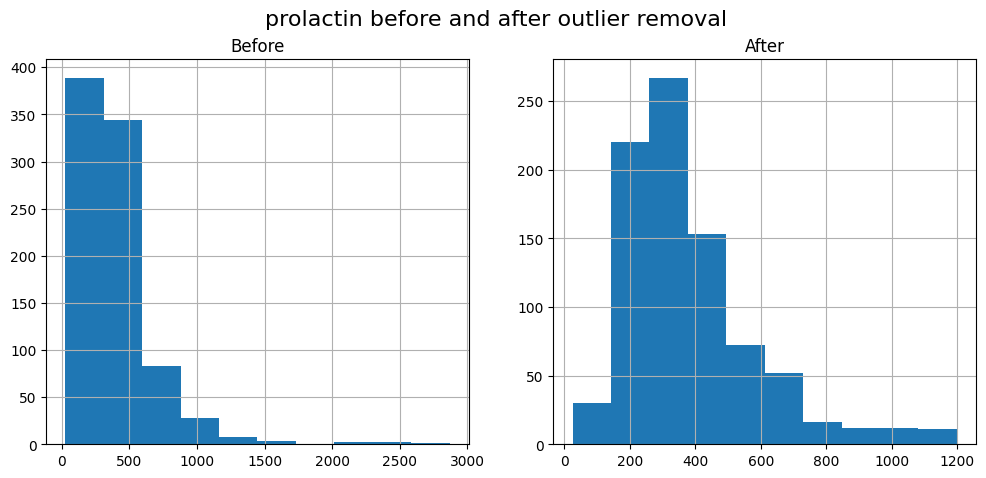

In [9]:
df = remove_outliers(raw_df, PROLACTIN)

In [10]:
df_prolactin_cleaned = df.dropna(subset=[PROLACTIN])

X_prolactin, y_prolactin = df_prolactin_cleaned.drop(columns=[PROLACTIN]), df_prolactin_cleaned[PROLACTIN]
X_train_prolactin, X_test_prolactin, y_train_prolactin, y_test_prolactin = train_test_split(X_prolactin, y_prolactin, test_size=0.2, random_state=42)

In [11]:
continuous_preprocessor = Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))])
tree_continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])

# continuous_preprocessor = Pipeline([('scaler', StandardScaler()), ('imputer', KNNImputer(n_neighbors=9))])

# categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])
categorical_preprocessor = Pipeline([('imputer', IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=10, n_jobs=-1), max_iter=40, initial_strategy='most_frequent')), ('one_hot_encoder', OneHotEncoder(handle_unknown='error', drop='if_binary'))])


## Hyperparameter tuning

In [5]:
# models = [
#         DecisionTreeRegressor(max_depth=7, random_state=42),
#         Lasso(),
#         Ridge(),
#         RandomForestRegressor(),
#         ]


# continuous_preprocessings = {
#     'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
#     'PT_KNN': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
#     'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
#     'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
# }

# categorical_preprocessings = {
#     'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
#     # 'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
#     # 'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
# }


# scores_df = explore_all_variations_of_preprocessing(X_train_prolactin, y_train_prolactin, PROLACTIN, models, continuous_preprocessings, categorical_preprocessings)
# scores_df

### Lasso

Fitting 15 folds for each of 8 candidates, totalling 120 fits


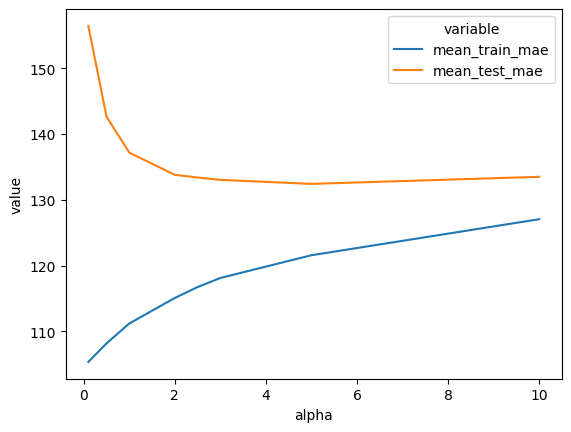

alpha  mean_train_mae  mean_test_mae
0   0.1      105.350209     156.416496
1   0.5      108.172300     142.622043
2     1      111.193689     137.157919
3     2      115.070814     133.784092
4   2.5      116.733365     133.379921
5     3      118.110251     133.019551
6     5      121.567414     132.407890
7    10      127.038454     133.482673

In [16]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.1, 0.5, 1, 2, 2.5, 3, 5, 10],
    }

prolactin_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_prolactin, y_train_prolactin, PROLACTIN, Lasso(), continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
prolactin_lasso_model_hyperparam_tuning_df

Chosen alpha: 2

### Ridge

Fitting 15 folds for each of 6 candidates, totalling 90 fits


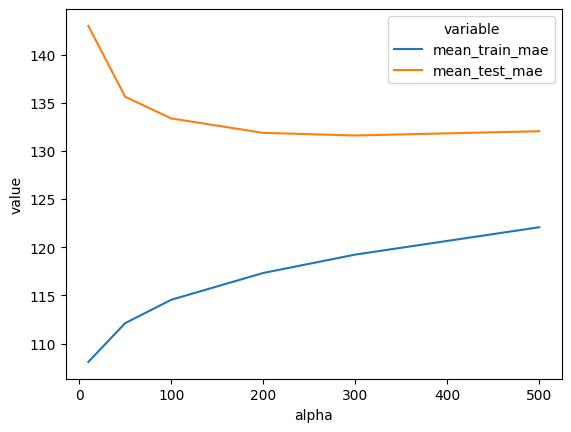

alpha  mean_train_mae  mean_test_mae
0    10      108.104635     142.972337
1    50      112.126221     135.625787
2   100      114.551525     133.376907
3   200      117.332797     131.875968
4   300      119.242352     131.602389
5   500      122.079614     132.045416

In [19]:
ridge_param_grid = {
    "model__alpha": [10, 50, 100, 200, 300, 500],
    }

prolactin_ridge_model_hyperparam_tuning_df =  hyperparameter_tuning_linear(X_train_prolactin, y_train_prolactin, PROLACTIN, Ridge(), continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
prolactin_ridge_model_hyperparam_tuning_df

Chosen alpha: 100

### Decision Tree Regressor

In [89]:
tree_param_grid = {
    "model__criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
    "model__max_depth": [7, 10, 15, 20, 25, 30],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 30],
    "model__min_samples_leaf": [10, 20],
    }

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_prolactin, y_train_prolactin, PROLACTIN, DecisionTreeRegressor(), continuous_preprocessor, categorical_preprocessor, tree_param_grid)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 96 candidates, totalling 1440 fits


params  mean_train_mae  mean_test_mae
46  {'model__criterion': 'absolute_error', 'model__max_depth': 30, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}      118.772749     141.538580
34  {'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}      119.152383     142.766080
42  {'model__criterion': 'absolute_error', 'model__max_depth': 25, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}      118.813298     142.829139
39  {'model__criterion': 'absolute_error', 'model__max_depth': 20, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}      119.585455     143.131630
27   {'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}      119.421653     143.444539
30  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}      119.309915     143.462271
38  {'model__criterion': 'absolute_error', 'model__max_depth': 20, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}      118.887667     143.549399
31  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}      118.850801     143.821541
26   {'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}      119.965071     144.142315
43  {'model__criterion': 'absolute_error', 'model__max_depth': 25, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}      117.832758     144.845837
35  {'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}      119.632046     144.880399
25   {'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}      113.414486     144.884230
47  {'model__criterion': 'absolute_error', 'model__max_depth': 30, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}      119.769755     145.562538
10   {'model__criterion': 'squared_error', 'model__max_depth': 15, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}      125.096268     145.983963
11   {'model__criterion': 'squared_error', 'model__max_depth': 15, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}      125.536217     146.295554
33  {'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}      109.480091     146.600340
71         {'model__criterion': 'poisson', 'model__max_depth': 30, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}      125.085601     147.147893
94    {'model__criterion': 'friedman_mse', 'model__max_depth': 30, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}      125.800752     147.566345
29  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}      111.345028     147.743480
19   {'model__criterion': 'squared_error', 'model__max_depth': 25, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}      125.976694     147.855514
87    {'model__criterion': 'friedman_mse', 'model__max_depth': 20, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}    

In [ ]:
model = DecisionTreeRegressor(criterion="absolute_error", max_depth=15, min_samples_leaf=20, min_samples_split=15, splitter='random')

tuned_df = compare_random_states(X_train_prolactin, y_train_prolactin, model, PROLACTIN, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

In [90]:
param_grid_rf = {
    'model__criterion': ['absolute_error'],
    'model__n_estimators': [100, 200],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [None],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [3, 5, 10, 15],
}

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_prolactin, y_train_prolactin, PROLACTIN, RandomForestRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 48 candidates, totalling 720 fits


params  mean_train_mae  mean_test_mae
17  {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__n_estimators': 200}      106.691362     132.739884
19   {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 5, 'model__n_estimators': 200}      113.490329     132.744639
16  {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__n_estimators': 100}      106.751302     132.836743
23  {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__n_estimators': 200}      113.482256     133.018744
12   {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}      106.822118     133.028398
21  {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 10, 'model__n_estimators': 200}      113.439099     133.061736
22  {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__n_estimators': 100}      113.367610     133.079064
13   {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}      106.640264     133.082615
20  {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 10, 'model__n_estimators': 100}      113.444833     133.083857
18   {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 5, 'model__n_estimators': 100}      113.690313     133.215110
15  {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200}      106.901155     133.246240
7     {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}       92.367013     133.295406
6     {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}       92.720622     133.343667
11   {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 15, 'model__n_estimators': 200}       96.666079     133.366818
14  {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 10, 'model__n_estimators': 100}      106.801398     133.485557
9    {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}       92.564603     133.531757
10   {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 15, 'model__n_estimators': 100}       96.815934     133.606801
8    {'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 10

In [95]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, max_features='sqrt', min_samples_leaf=10, min_samples_split=15, criterion='absolute_error')

tuned_df = compare_random_states(X_train_prolactin, y_train_prolactin, rf_model, PROLACTIN, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:47<00:00,  5.93s/it]


cv_mae
77 -131.976783
13 -131.980574
51 -132.062907
76 -132.249041
27 -132.250816

## Best models for prolactin

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


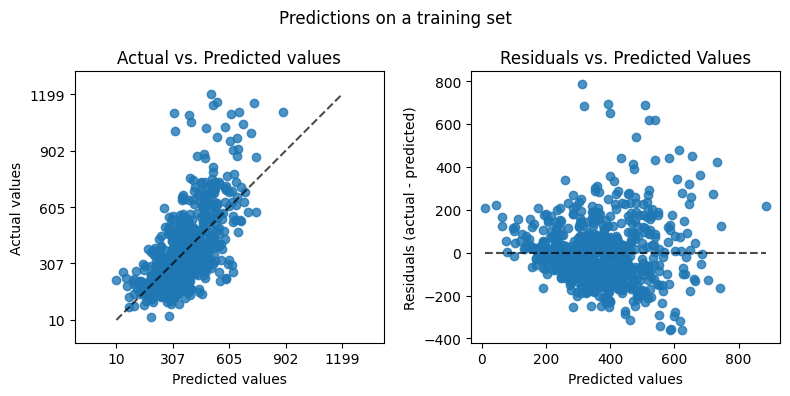

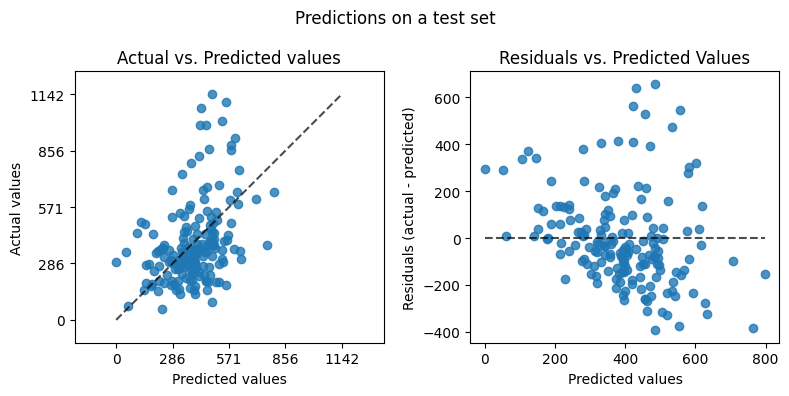

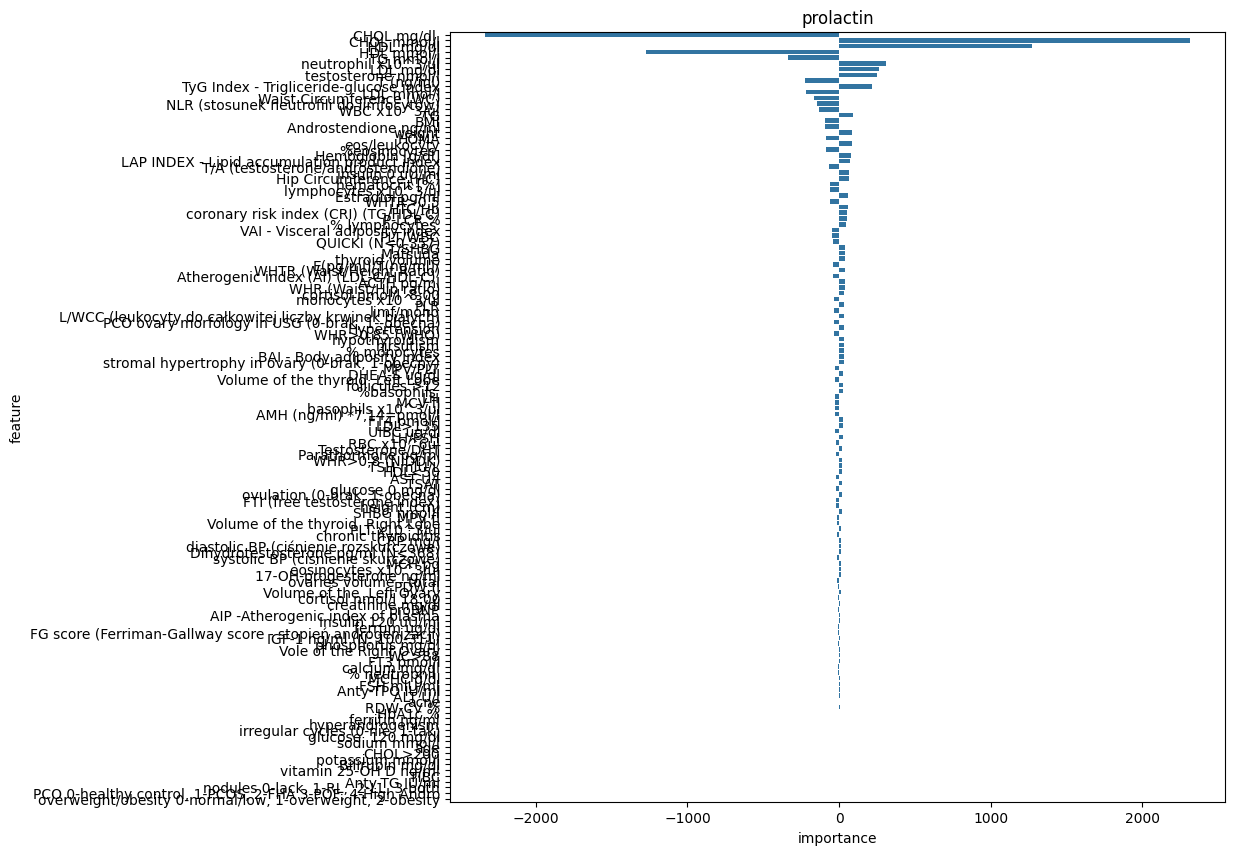

model  data_set        mse      mae     rmse     r2
0  LinearRegression()  training  23665.592  113.443  153.836  0.398
1  LinearRegression()      test  40370.943  151.326  200.925  0.076

In [12]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


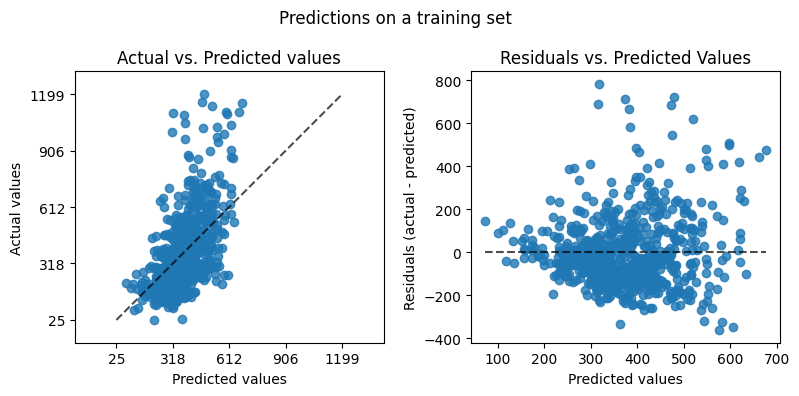

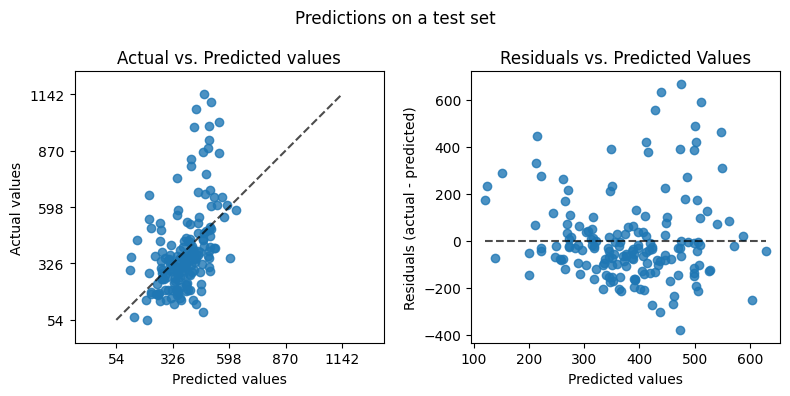

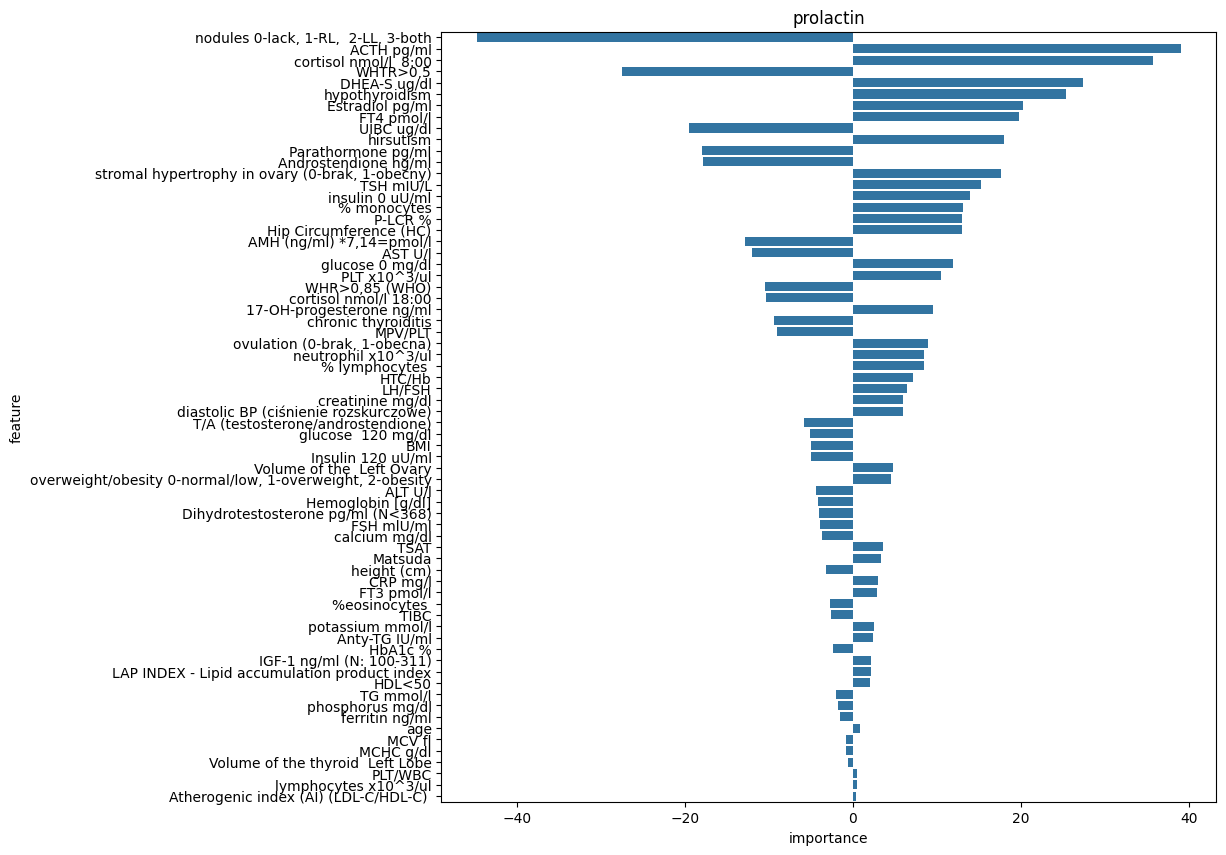

model  data_set        mse      mae     rmse     r2
0  Lasso(alpha=2)  training  26876.422  120.498  163.940  0.316
1  Lasso(alpha=2)      test  34022.336  131.515  184.451  0.221

In [13]:
lasso_model = Lasso(alpha=2)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


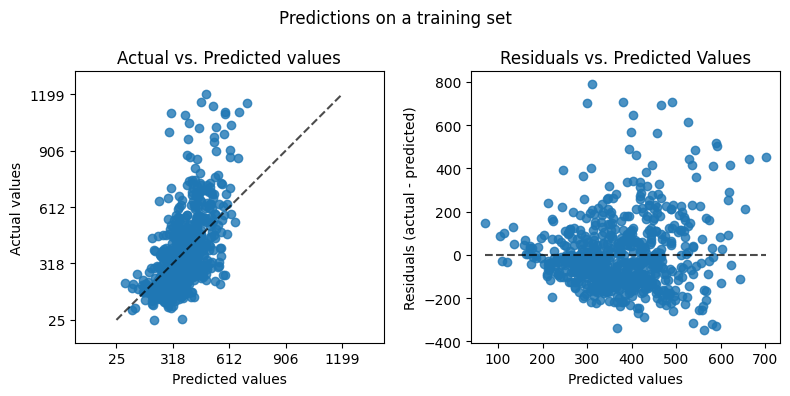

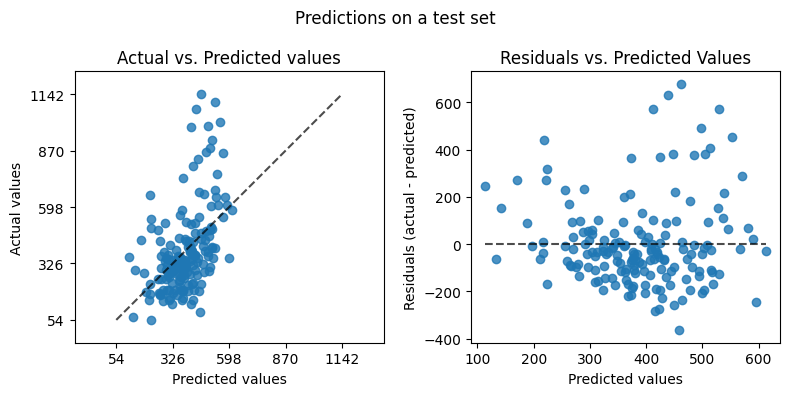

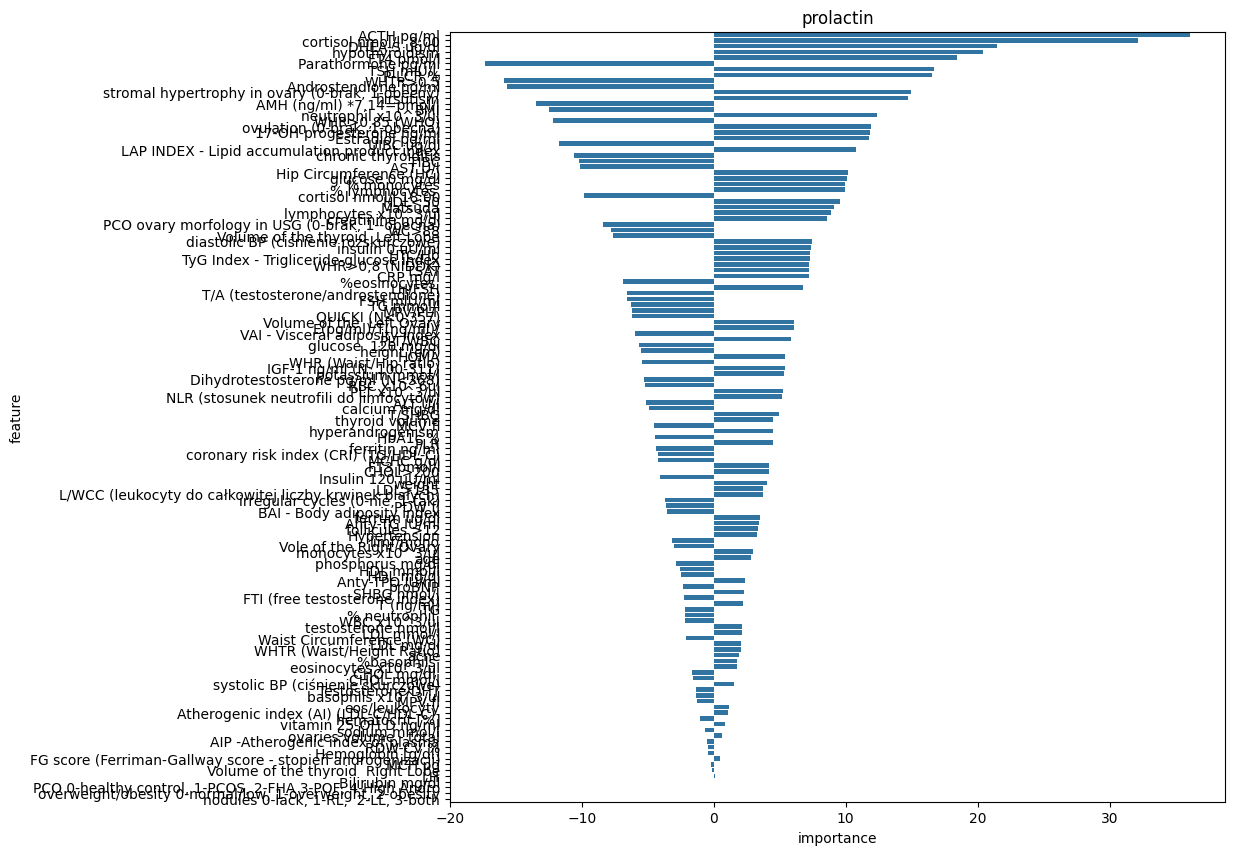

model  data_set        mse      mae     rmse     r2
0  Ridge(alpha=100)  training  26480.239  119.603  162.727  0.326
1  Ridge(alpha=100)      test  33437.172  131.281  182.858  0.235

In [14]:
ridge_model = Ridge(alpha=100)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


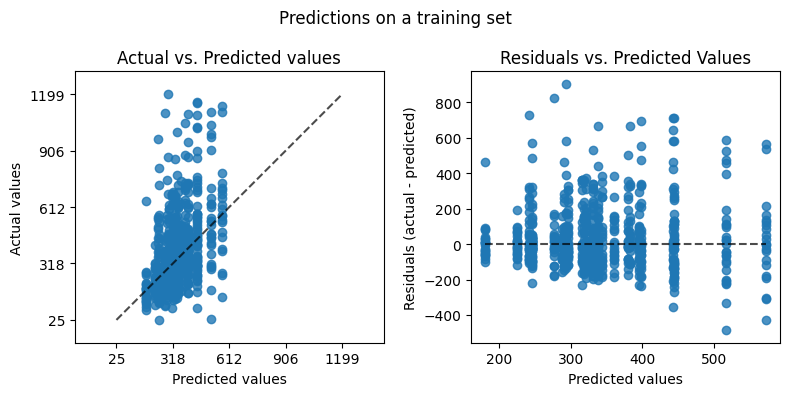

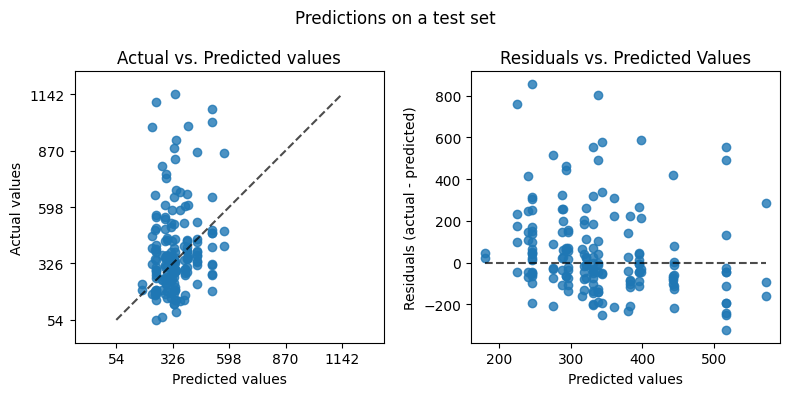

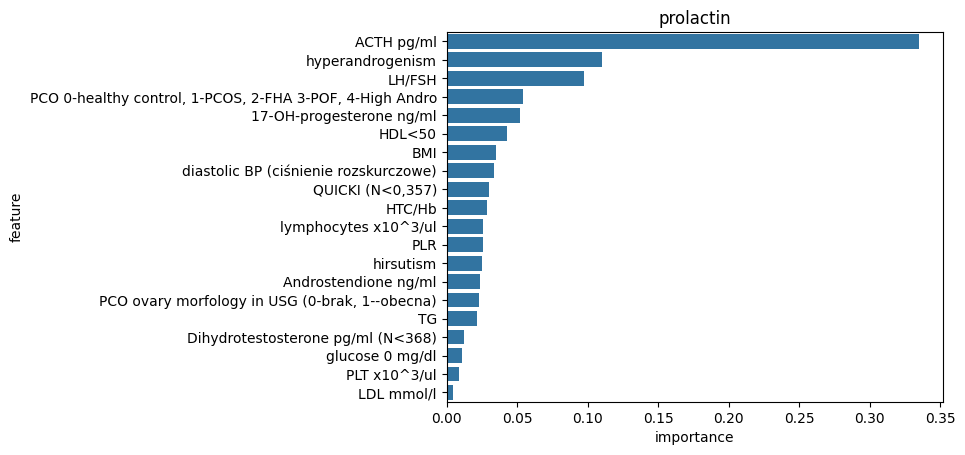

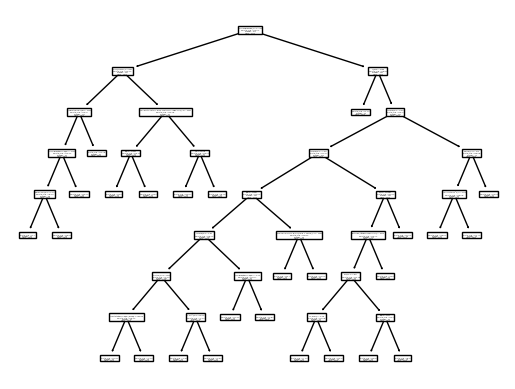

model  data_set        mse      mae     rmse     r2
0  DecisionTreeRegressor(criterion='absolute_error', max_depth=15,\n                      min_samples_leaf=20, min_samples_split=15,\n                      random_state=54, splitter='random')  training  32878.912  121.460  181.325  0.163
1  DecisionTreeRegressor(criterion='absolute_error', max_depth=15,\n                      min_samples_leaf=20, min_samples_split=15,\n                      random_state=54, splitter='random')      test  46073.704  148.331  214.648 -0.054

In [15]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=15, min_samples_leaf=20, min_samples_split=15, splitter='random', random_state=54)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, tree_continuous_preprocessor, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


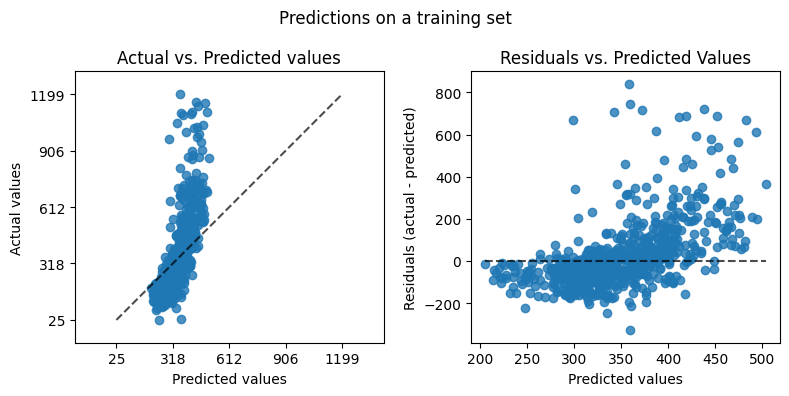

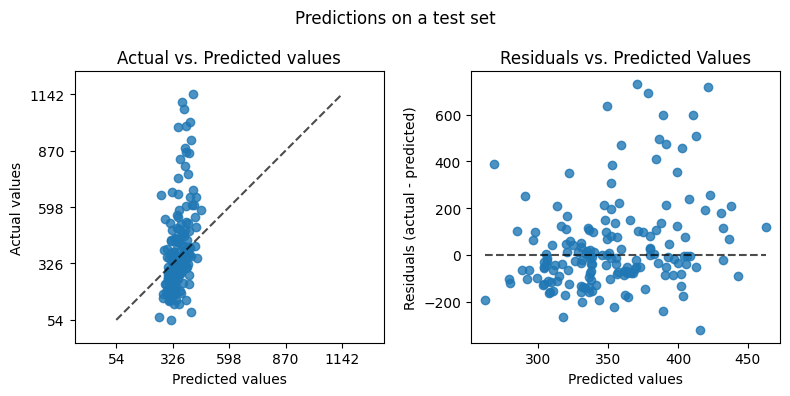

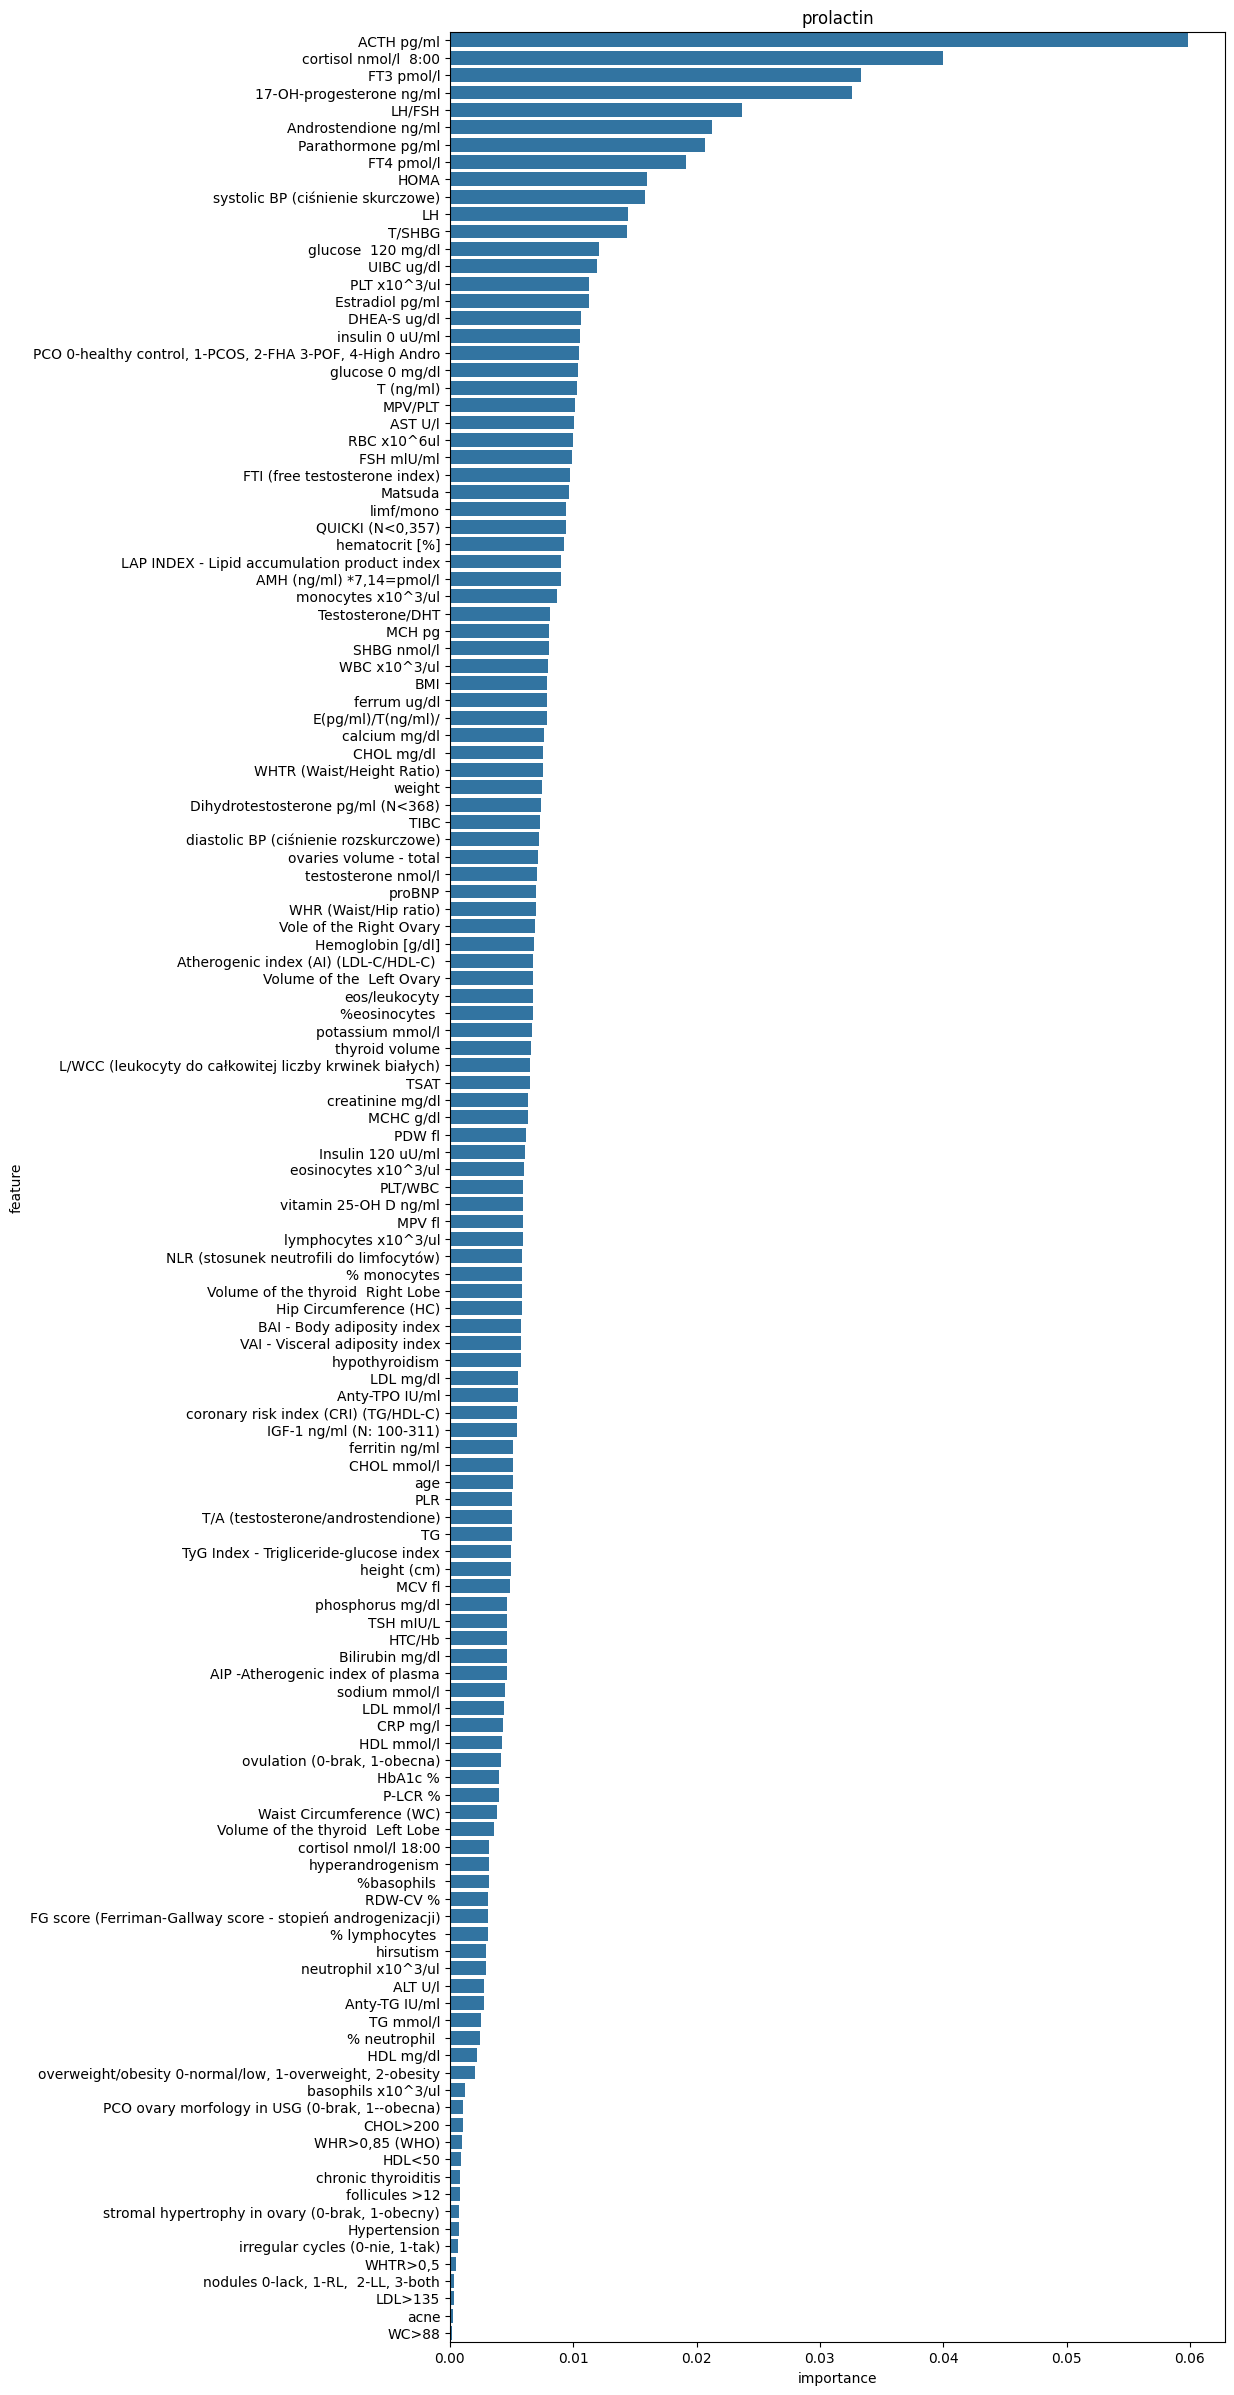

model  data_set        mse      mae     rmse     r2
0  RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n                      min_samples_leaf=10, min_samples_split=15,\n                      random_state=77)  training  26578.132  107.627  163.028  0.323
1  RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n                      min_samples_leaf=10, min_samples_split=15,\n                      random_state=77)      test  39022.722  133.237  197.542  0.107

In [16]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, max_features='sqrt', min_samples_leaf=10, min_samples_split=15, criterion='absolute_error', random_state=77)
vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, tree_continuous_preprocessor, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df

## Best models on subsets of data

In [12]:
def difference_of_sets(set1, set2):
    return set(set1) - set(set2)

featureset_variations = {}

# without the obviously related features
cropped_featureset = difference_of_sets(X_prolactin.columns, prolactin_associated_features)
featureset_variations['cropped'] = cropped_featureset

#  inflammatory attributes
inflammatory_featureset = difference_of_sets(inflammatory_attributes, prolactin_associated_features)
featureset_variations['inflammatory'] = inflammatory_featureset


Featureset: cropped
Model: LinearRegression


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


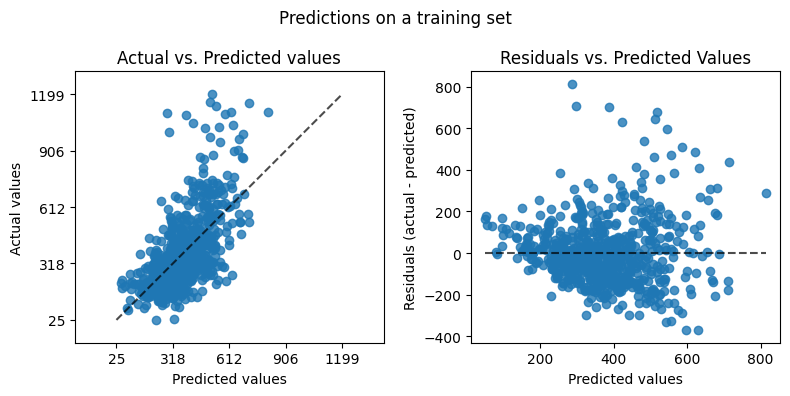

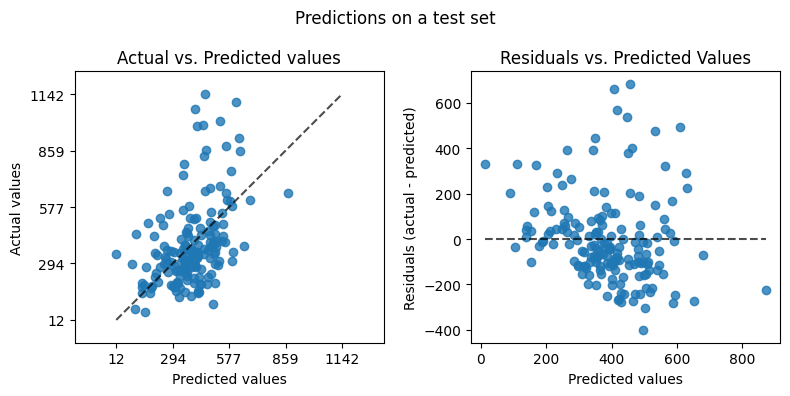

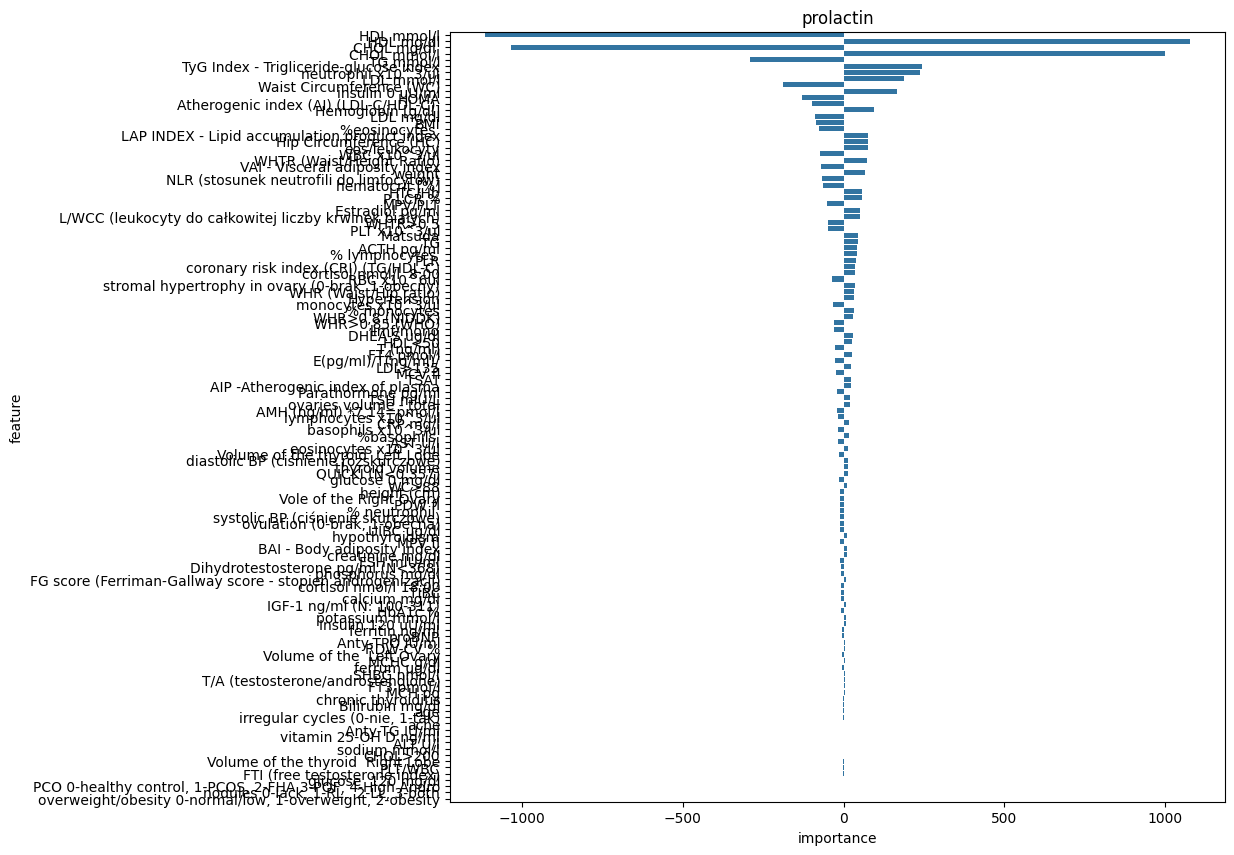

                model  data_set        mse      mae     rmse     r2
0  LinearRegression()  training  24358.776  114.813  156.073  0.380
1  LinearRegression()      test  36888.179  142.497  192.063  0.156

Model: Lasso


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


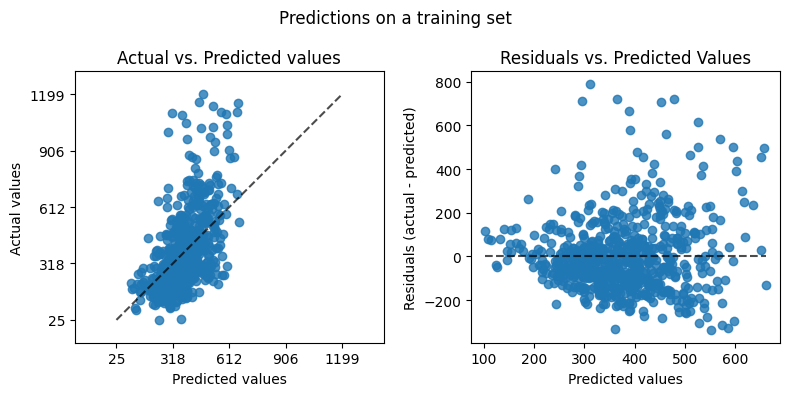

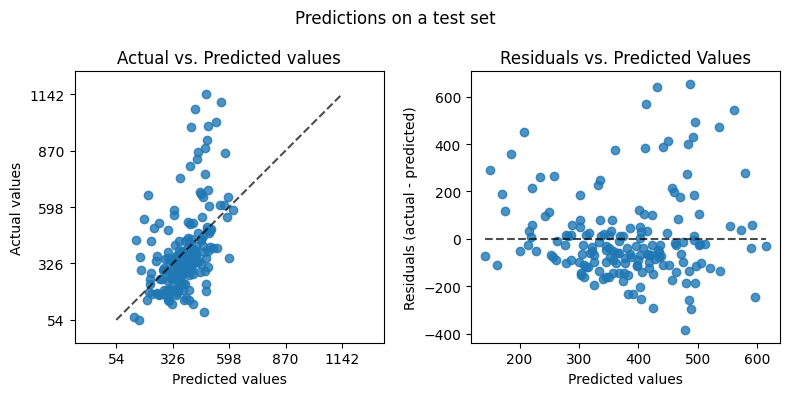

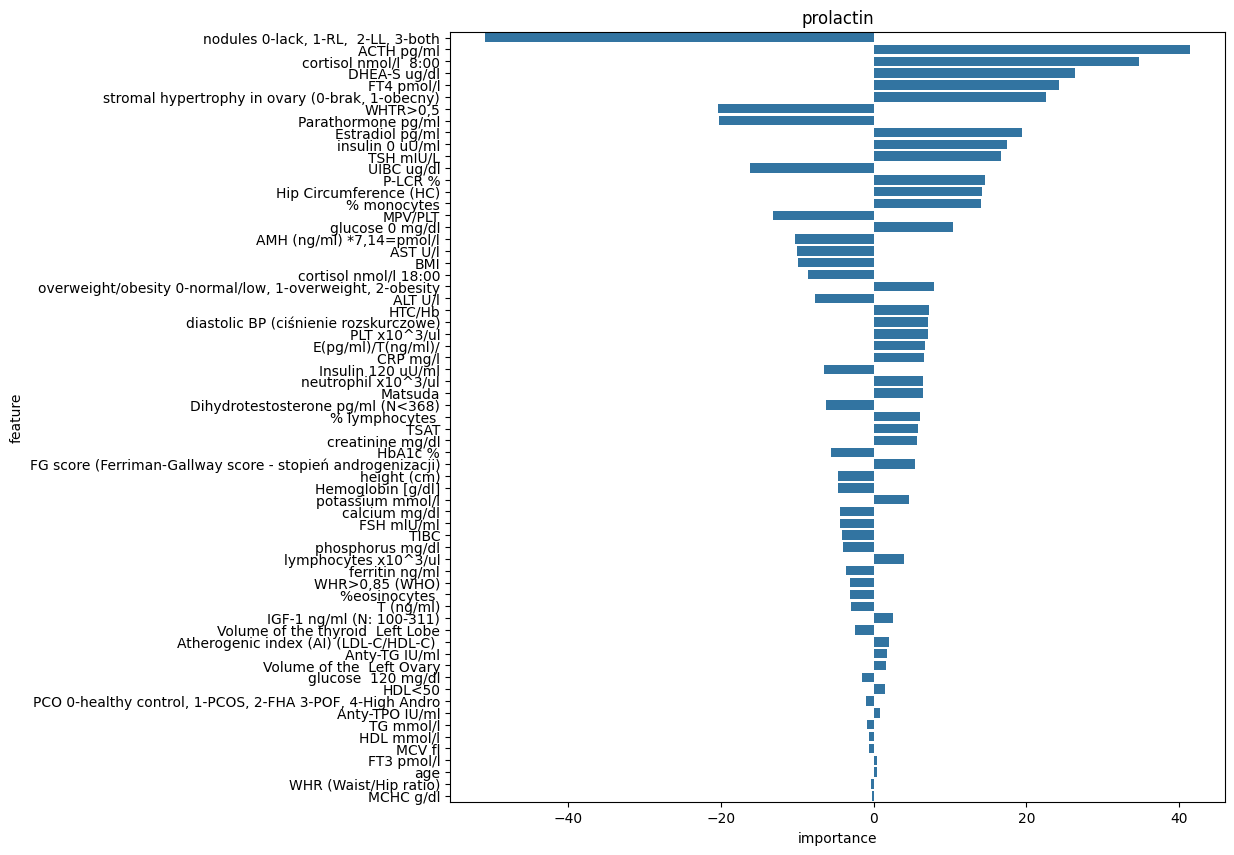

            model  data_set        mse      mae     rmse     r2
0  Lasso(alpha=2)  training  27361.351  121.300  165.413  0.303
1  Lasso(alpha=2)      test  33605.037  130.805  183.317  0.231

Model: Ridge


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


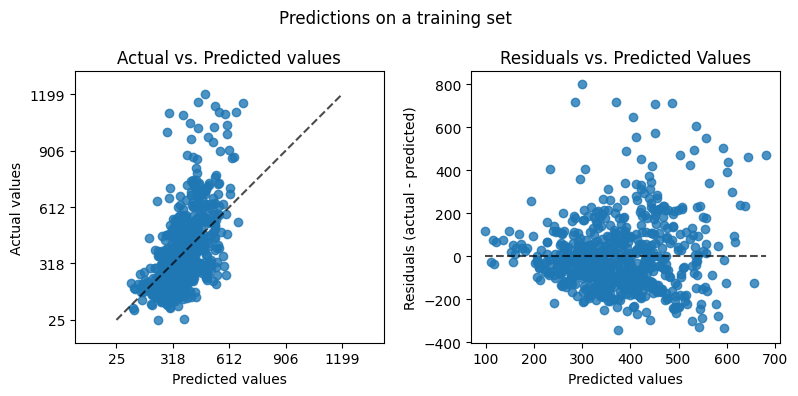

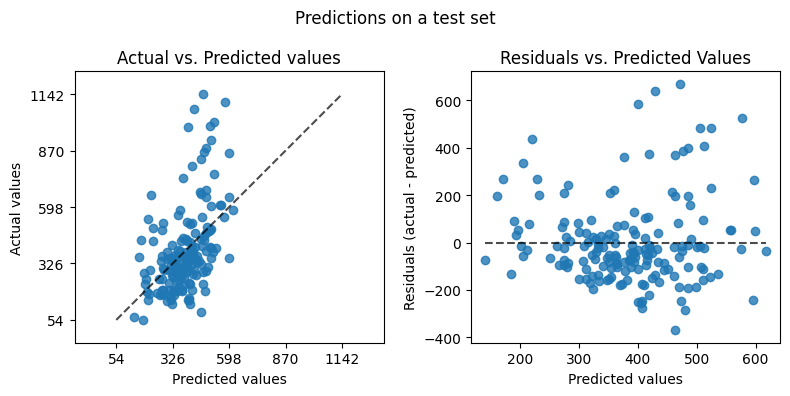

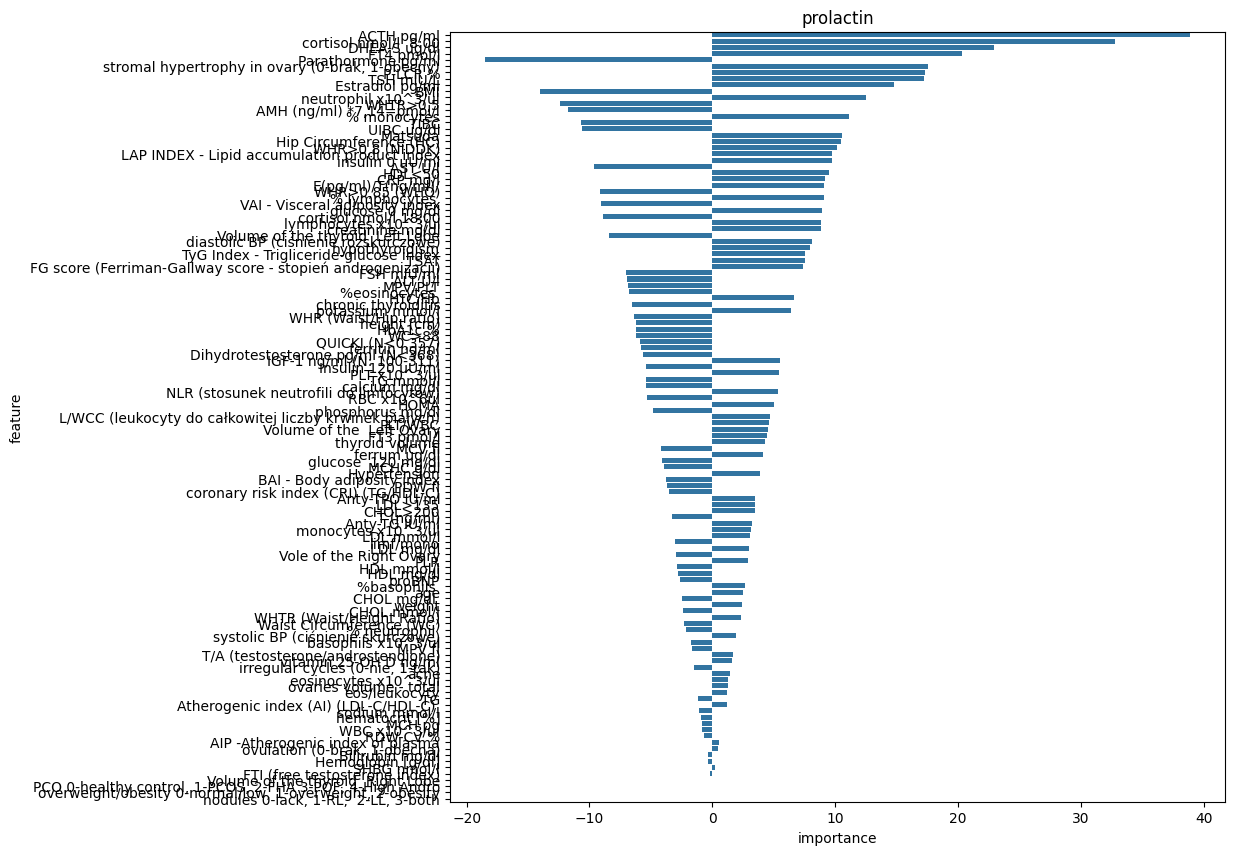

              model  data_set        mse      mae     rmse     r2
0  Ridge(alpha=100)  training  26957.915  120.584  164.189  0.314
1  Ridge(alpha=100)      test  33228.040  131.198  182.286  0.240

Featureset: inflammatory
Model: LinearRegression


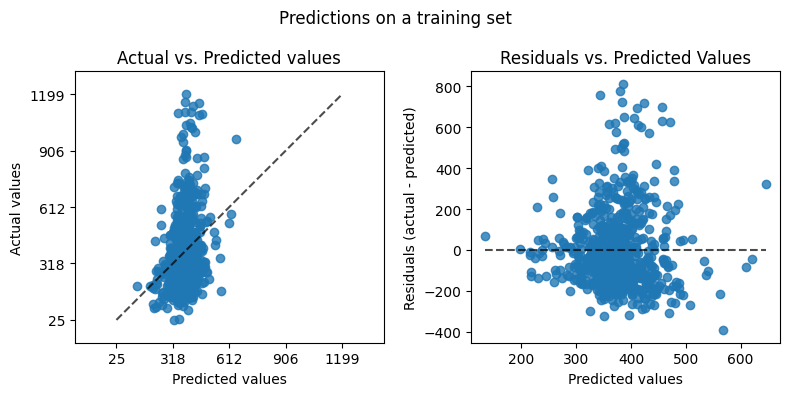

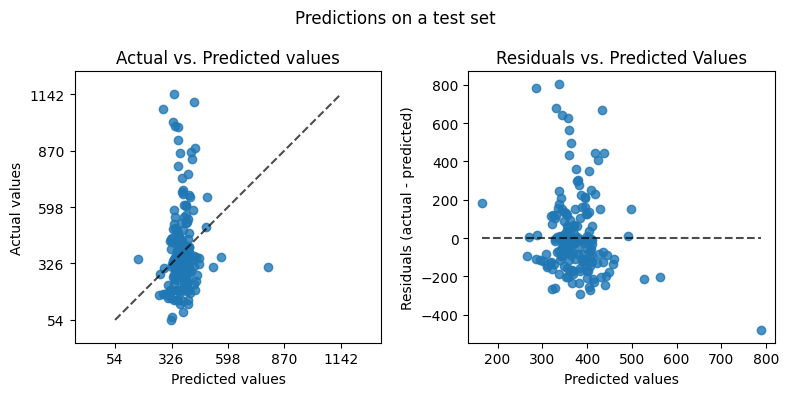

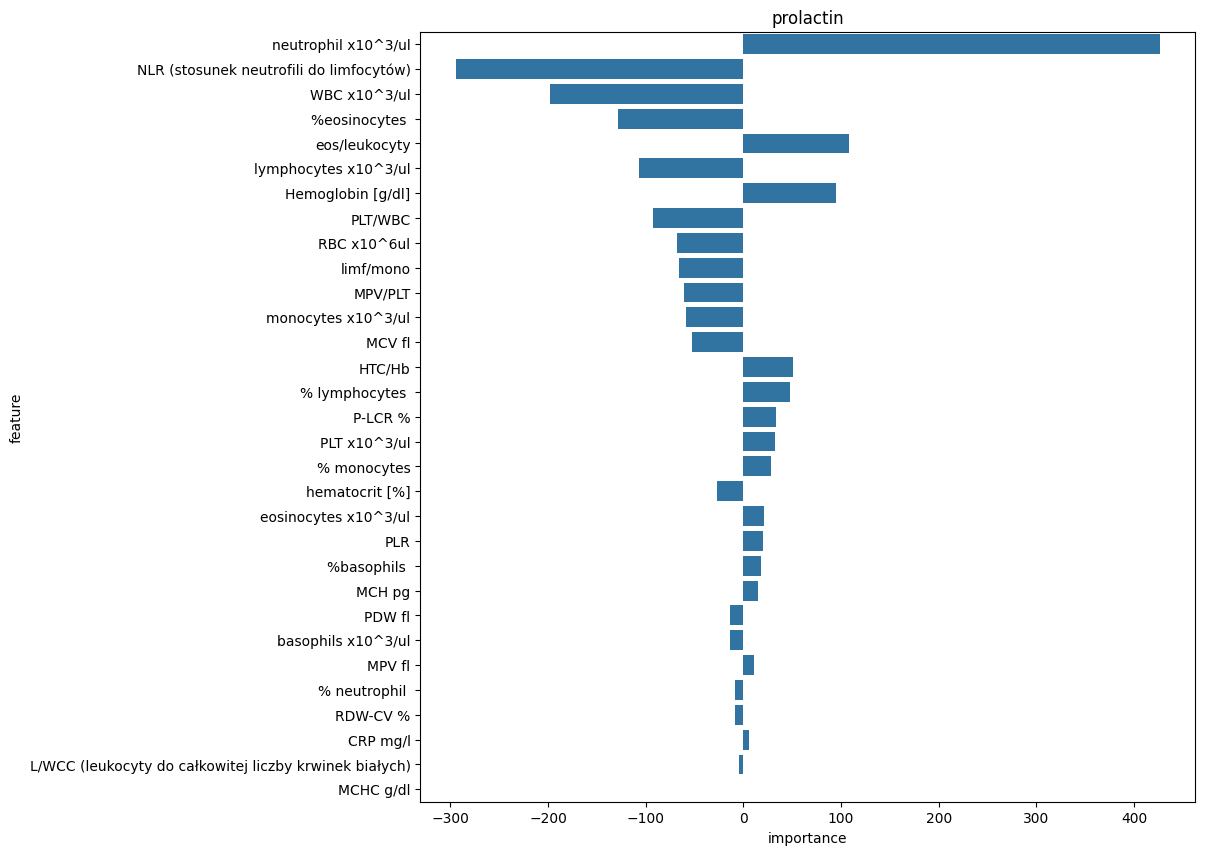

                model  data_set        mse      mae     rmse     r2
0  LinearRegression()  training  36133.063  143.624  190.087  0.080
1  LinearRegression()      test  45233.571  150.877  212.682 -0.035

Model: Lasso


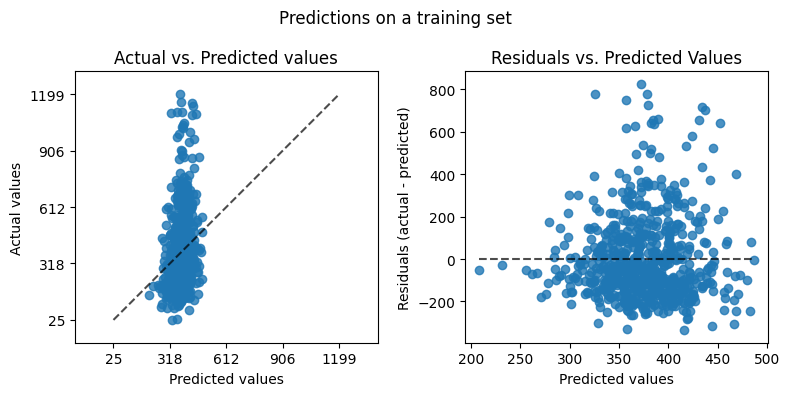

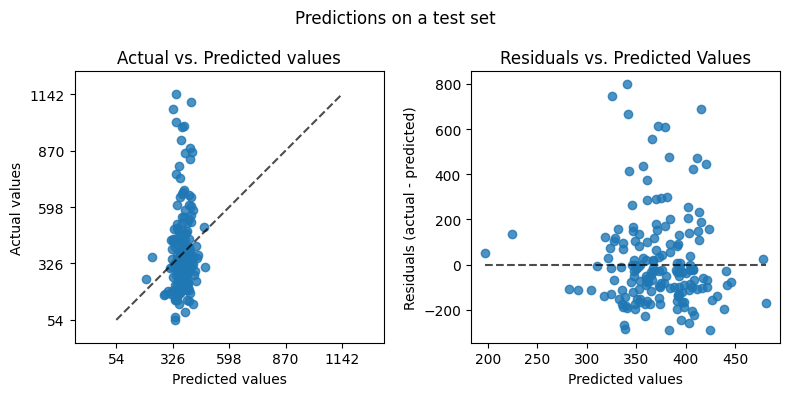

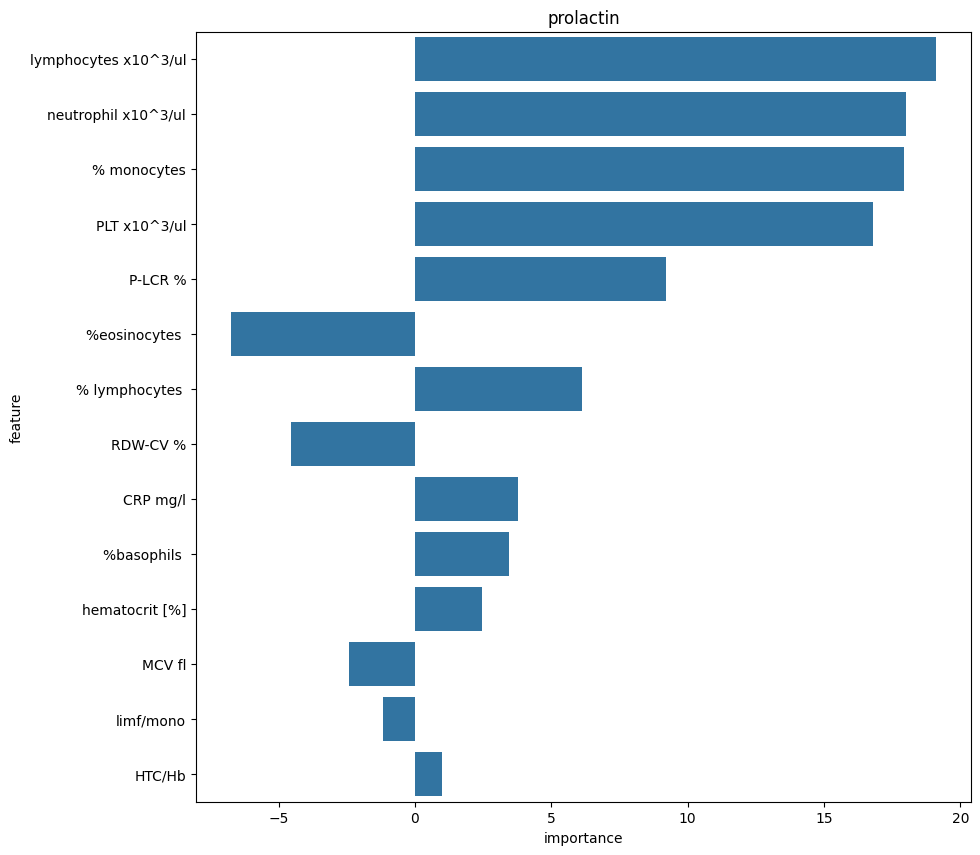

            model  data_set        mse      mae     rmse     r2
0  Lasso(alpha=2)  training  37284.218  145.833  193.091  0.051
1  Lasso(alpha=2)      test  43398.546  148.447  208.323  0.007

Model: Ridge


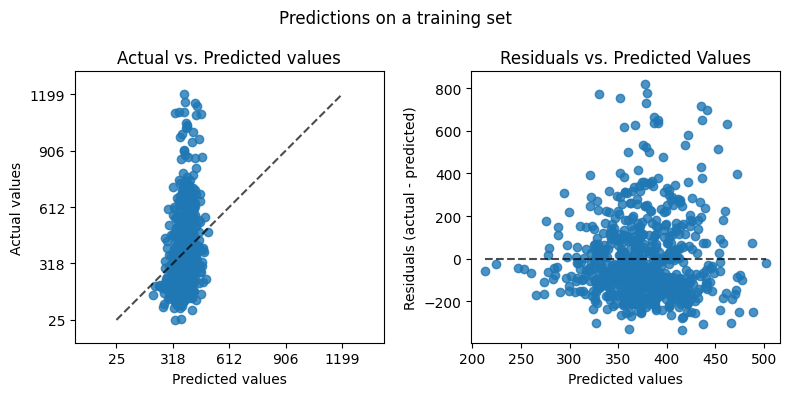

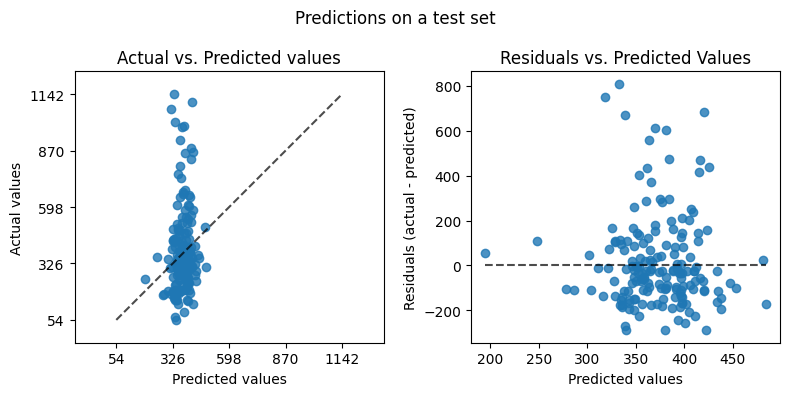

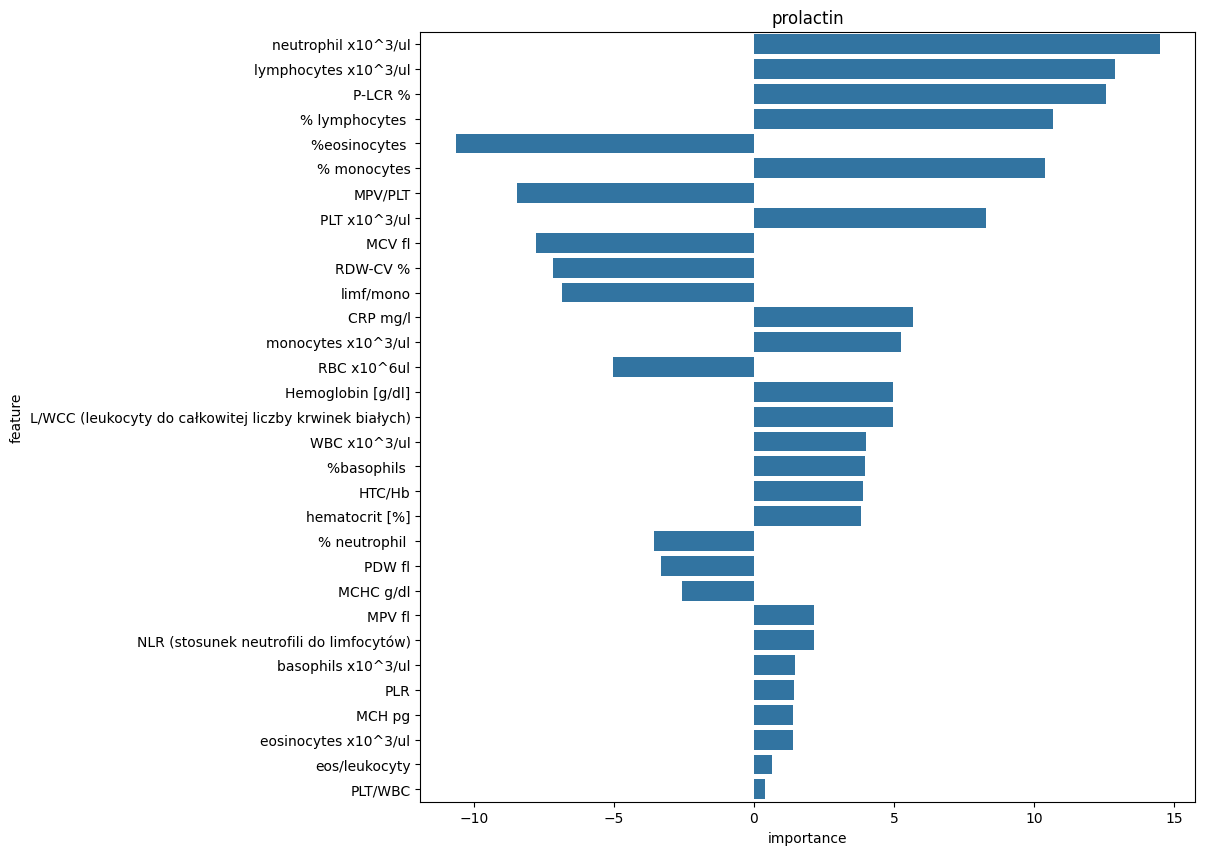

              model  data_set        mse      mae     rmse     r2
0  Ridge(alpha=100)  training  37186.759  145.616  192.839  0.053
1  Ridge(alpha=100)      test  43301.106  148.369  208.089  0.009



In [16]:
models = {
    'LinearRegression': (LinearRegression(), get_feature_importance_lasso, continuous_preprocessor),
    'Lasso': (Lasso(alpha=2), get_feature_importance_lasso, continuous_preprocessor),
    'Ridge': (Ridge(alpha=100), get_feature_importance_lasso, continuous_preprocessor),
    # 'DecisionTree': (DecisionTreeRegressor(criterion="absolute_error", max_depth=8, min_samples_leaf=27, min_samples_split=17, splitter='random', random_state=62), get_feature_importance_tree, tree_continuous_preprocessor),
    # 'RandomForest': (RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56), get_feature_importance_rf, tree_continuous_preprocessor),
    # 'KNN': (KNeighborsRegressor(n_neighbors=5), get_feature_importance_tree)
}


for featureset_name, featureset in featureset_variations.items():
    print(f"Featureset: {featureset_name}")
    X_featureset = X_prolactin[list(featureset)]
    X_train_featureset, X_test_featureset, y_train_featureset, y_test_featureset = train_test_split(X_featureset, y_prolactin, test_size=0.2, random_state=42)

    for model_name, (model, feature_importance_method, cont_preprocessor) in models.items():
        print(f"Model: {model_name}")
        # for continuous_preprocessor in [tree_continuous_preprocessing, continuous_preprocessor, linear_continuous_preprocessor]:
        #     print(f"Continuous preprocessor: {continuous_preprocessor}")
        model_scores_df, feature_importances = train_model(model, PROLACTIN, X_train_featureset, y_train_featureset, X_test_featureset, y_test_featureset, cont_preprocessor, categorical_preprocessor, feature_importance_method)
        print(model_scores_df)
        print()


## Feature importances

In [7]:
selected_features_map = {}

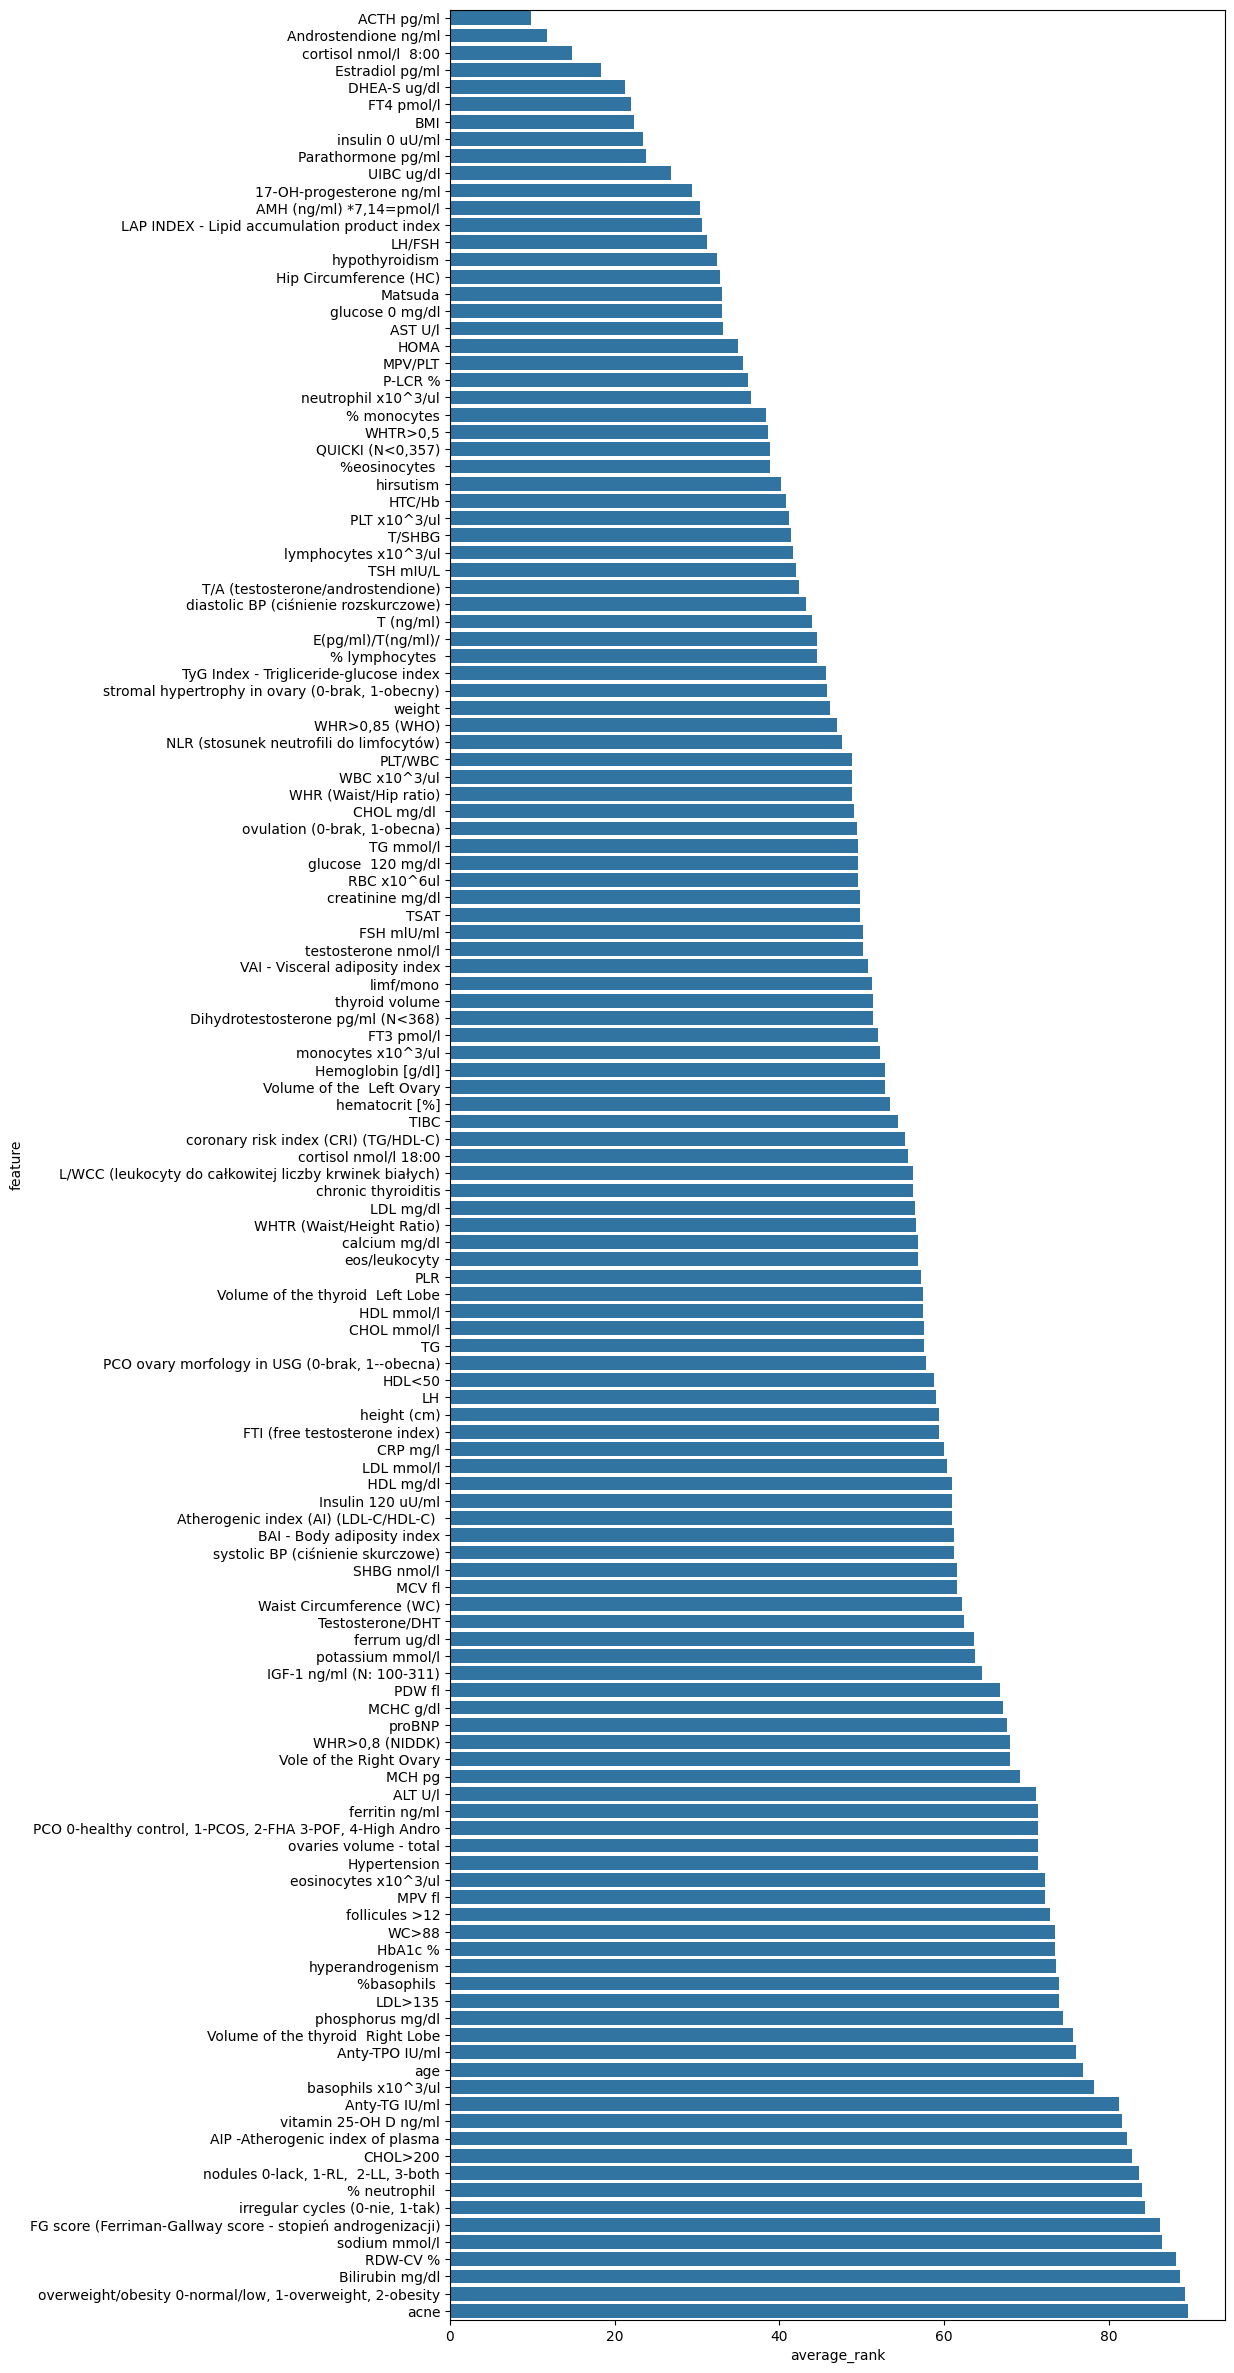

In [18]:
rename_importnace_col(feature_importnces_lr, 'linear_regression')
rename_importnace_col(feature_importnces_lasso, 'lasso')
rename_importnace_col(feature_importnces_ridge, 'ridge')
rename_importnace_col(feature_importnces_tree, 'tree')
rename_importnace_col(feature_importnces_rf, 'rf')

feature_importance_df = merge_feature_importances([feature_importnces_lr, feature_importnces_lasso, feature_importnces_ridge, feature_importnces_tree, feature_importnces_rf])

ranked_df = rank_importances(feature_importance_df)
ranked_df_sorted = ranked_df.sort_values(by='average_rank')

plt.figure(figsize=(10, 30))
sns.barplot(ranked_df_sorted, x="average_rank", y="feature")
plt.show()

In [20]:
overall_rank_top_features = ranked_df_sorted[ranked_df_sorted['average_rank'] < 50] # a cut found on the plot above
overall_rank_selected_features = list(overall_rank_top_features['feature'].values)

selected_features_map['average_rank'] = overall_rank_selected_features
print(f'Top {len(overall_rank_selected_features)} features:')
overall_rank_selected_features

Top 53 features:


['ACTH pg/ml',
 'Androstendione ng/ml',
 'cortisol nmol/l  8:00',
 'Estradiol pg/ml',
 'DHEA-S ug/dl',
 'FT4 pmol/l',
 'BMI',
 'insulin 0 uU/ml',
 'Parathormone pg/ml',
 'UIBC ug/dl',
 '17-OH-progesterone ng/ml',
 'AMH (ng/ml) *7,14=pmol/l',
 'LAP INDEX - Lipid accumulation product index',
 'LH/FSH',
 'hypothyroidism',
 'Hip Circumference (HC)',
 'Matsuda',
 'glucose 0 mg/dl',
 'AST U/l',
 'HOMA',
 'MPV/PLT',
 'P-LCR %',
 'neutrophil x10^3/ul',
 '% monocytes',
 'WHTR>0,5',
 'QUICKI (N<0,357)',
 '%eosinocytes ',
 'hirsutism',
 'HTC/Hb',
 'PLT x10^3/ul',
 'T/SHBG',
 'lymphocytes x10^3/ul',
 'TSH mIU/L',
 'T/A (testosterone/androstendione)',
 'diastolic BP (ciśnienie rozskurczowe)',
 'T (ng/ml)',
 'E(pg/ml)/T(ng/ml)/',
 '% lymphocytes ',
 'TyG Index - Trigliceride-glucose index',
 'stromal hypertrophy in ovary (0-brak, 1-obecny)',
 'weight',
 'WHR>0,85 (WHO)',
 'NLR (stosunek neutrofili do limfocytów)',
 'PLT/WBC',
 'WBC x10^3/ul',
 'WHR (Waist/Hip ratio)',
 'CHOL mg/dl ',
 'ovulation (0-

## Feature selection methods

### Mutual info

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


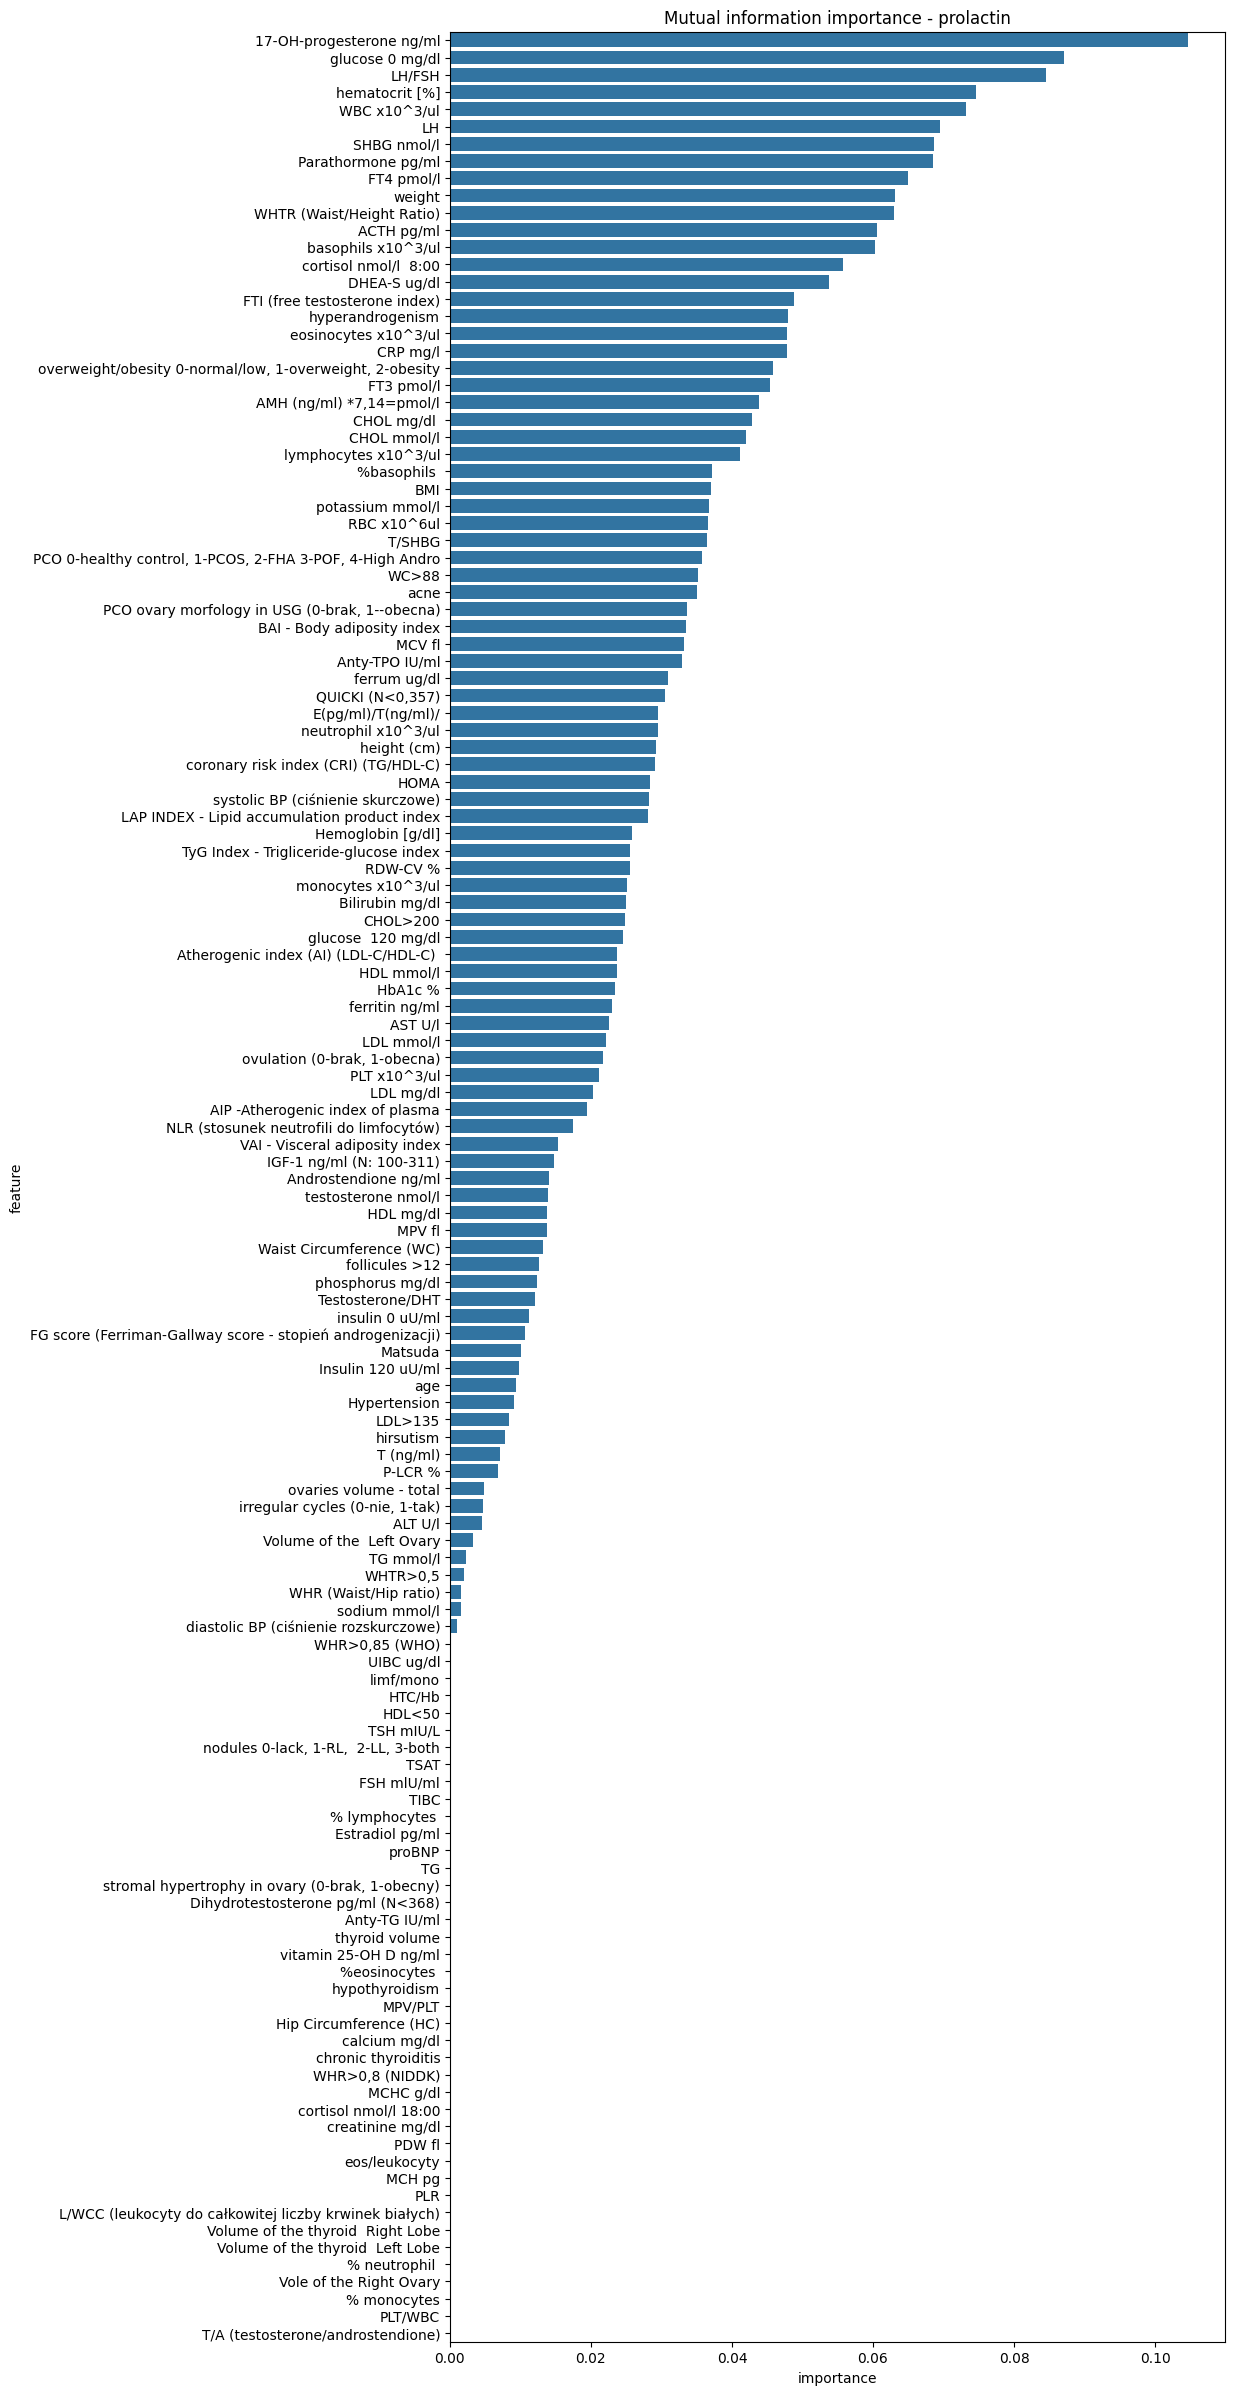

Selected 93 features


In [9]:
selected_feature_names_mutual_info = feature_selection_mutual_info_regression(X_train_prolactin, y_train_prolactin, PROLACTIN, continuous_preprocessor, categorical_preprocessor)
selected_feature_names_mutual_info = selected_feature_names_mutual_info[selected_feature_names_mutual_info['importance'] > 0]

selected_feature_names_mutual_info.reset_index(drop=True, inplace=True)
print(f'Selected {len(selected_feature_names_mutual_info)} features')
selected_features_map['mutual_info'] = list(selected_feature_names_mutual_info['feature'].values)
# selected_feature_names_mutual_info

### Recursive feature elimination

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Optimal number of features: 37


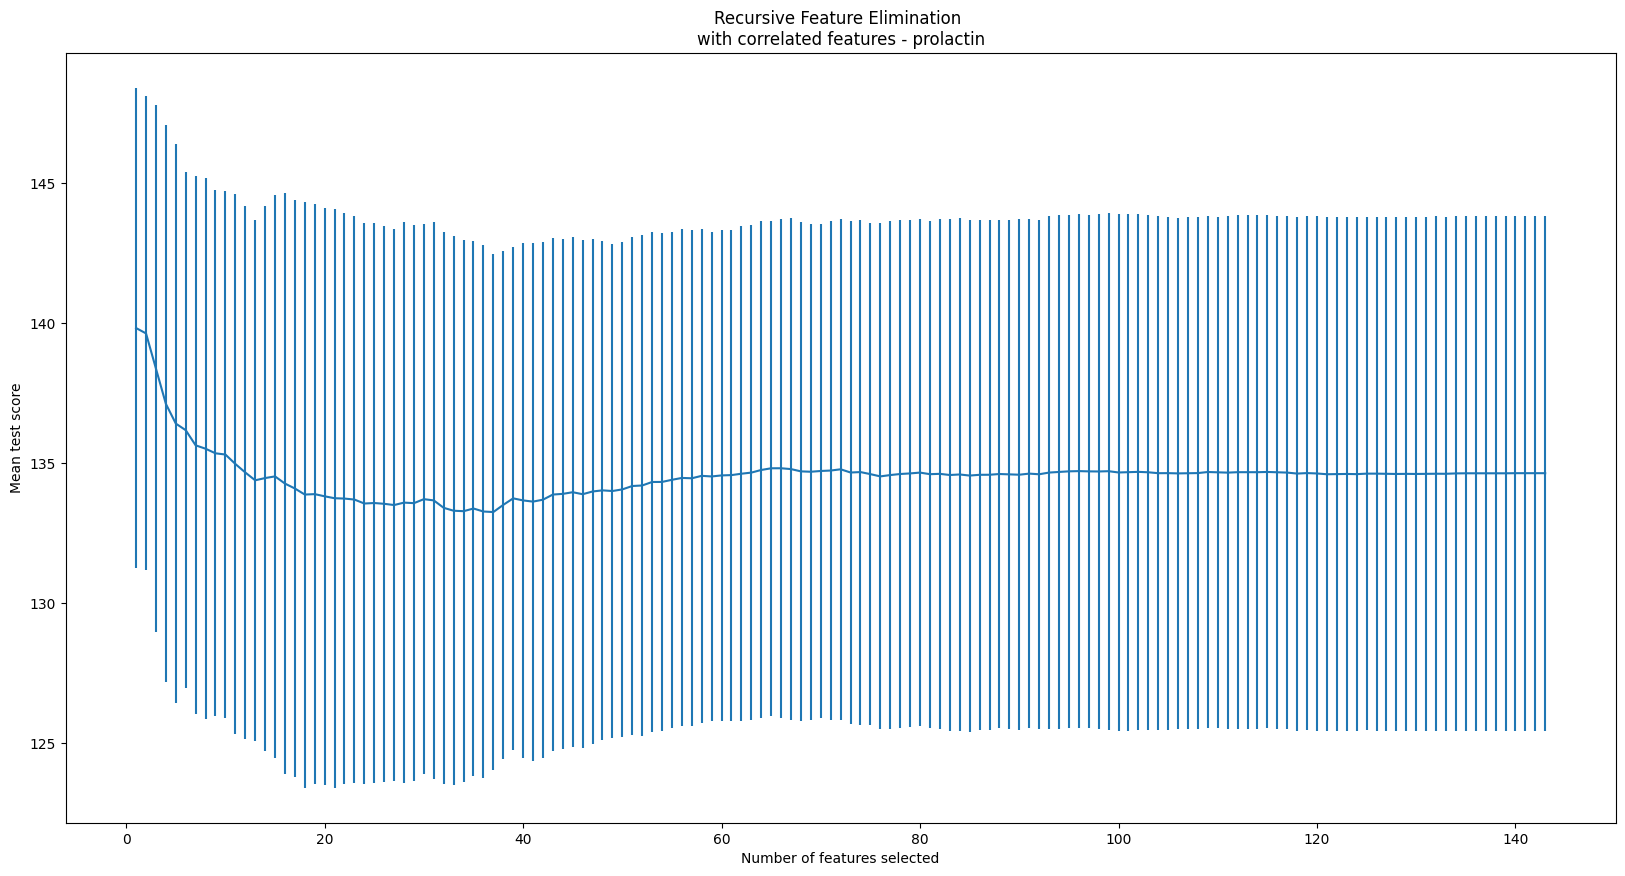

['UIBC ug/dl',
 'Estradiol pg/ml',
 'FT4 pmol/l',
 'Parathormone pg/ml',
 'HDL<50',
 'HTC/Hb',
 'insulin 0 uU/ml',
 'Hip Circumference (HC)',
 'DHEA-S ug/dl',
 'TSH mIU/L',
 'chronic thyroiditis',
 'hirsutism',
 'glucose 0 mg/dl',
 'MPV/PLT',
 'Matsuda',
 'P-LCR %',
 'PLT/WBC',
 'hypothyroidism',
 'cortisol nmol/l 18:00',
 'QUICKI (N<0,357)',
 'cortisol nmol/l  8:00',
 'AST U/l',
 'Androstendione ng/ml',
 'neutrophil x10^3/ul',
 'WHR>0,85 (WHO)',
 'ovulation (0-brak, 1-obecna)',
 'AMH (ng/ml) *7,14=pmol/l',
 'ACTH pg/ml',
 'WHTR>0,5',
 'WC>88',
 'stromal hypertrophy in ovary (0-brak, 1-obecny)',
 '% lymphocytes ',
 'nodules 0-lack, 1-RL,  2-LL, 3-both',
 '17-OH-progesterone ng/ml',
 '% monocytes']

In [23]:
# lasso_model = Lasso(alpha=1)
lasso_model = Ridge(alpha=100)

recursive_feature_elimination_ranked_features_lasso = recursive_feature_elimination(X_train_prolactin, y_train_prolactin, lasso_model, PROLACTIN, continuous_preprocessor, categorical_preprocessor)
selected_features_map['recursive_feature_elimination'] = list(recursive_feature_elimination_ranked_features_lasso[recursive_feature_elimination_ranked_features_lasso['ranking'] == 1]['feature'].values)
selected_features_map['recursive_feature_elimination']

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Optimal number of features: 28


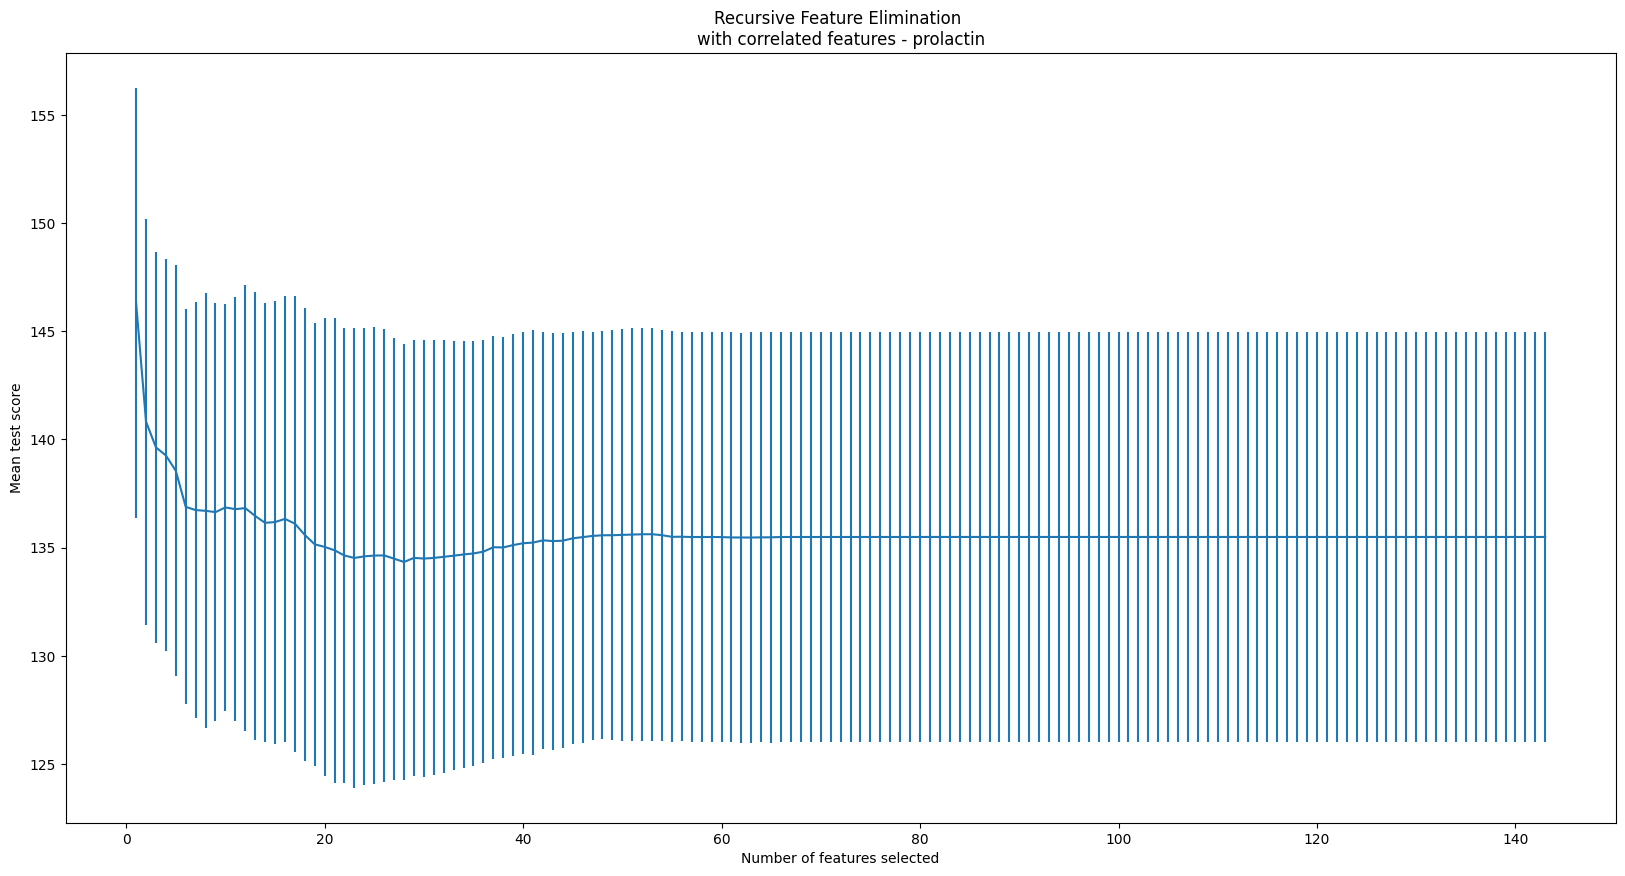

['P-LCR %',
 'FT4 pmol/l',
 'HTC/Hb',
 'UIBC ug/dl',
 'WHTR>0,5',
 'Estradiol pg/ml',
 'Parathormone pg/ml',
 'Hip Circumference (HC)',
 'DHEA-S ug/dl',
 'ovulation (0-brak, 1-obecna)',
 'Insulin 120 uU/ml',
 'insulin 0 uU/ml',
 'stromal hypertrophy in ovary (0-brak, 1-obecny)',
 'TSH mIU/L',
 'hirsutism',
 'WHR>0,85 (WHO)',
 'hypothyroidism',
 'chronic thyroiditis',
 'Androstendione ng/ml',
 'AST U/l',
 'AMH (ng/ml) *7,14=pmol/l',
 'nodules 0-lack, 1-RL,  2-LL, 3-both',
 'cortisol nmol/l  8:00',
 'ACTH pg/ml',
 '17-OH-progesterone ng/ml',
 '% monocytes',
 'glucose 0 mg/dl',
 'PLT x10^3/ul']

In [24]:
lasso_model = Lasso(alpha=2)
# lasso_model = Ridge(alpha=50)

recursive_feature_elimination_ranked_features_lasso = recursive_feature_elimination(X_train_prolactin, y_train_prolactin, lasso_model, PROLACTIN, continuous_preprocessor, categorical_preprocessor)
selected_features_map['recursive_feature_elimination'] = list(recursive_feature_elimination_ranked_features_lasso[recursive_feature_elimination_ranked_features_lasso['ranking'] == 1]['feature'].values)
selected_features_map['recursive_feature_elimination']

### Permutation importance

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


selected 132 features


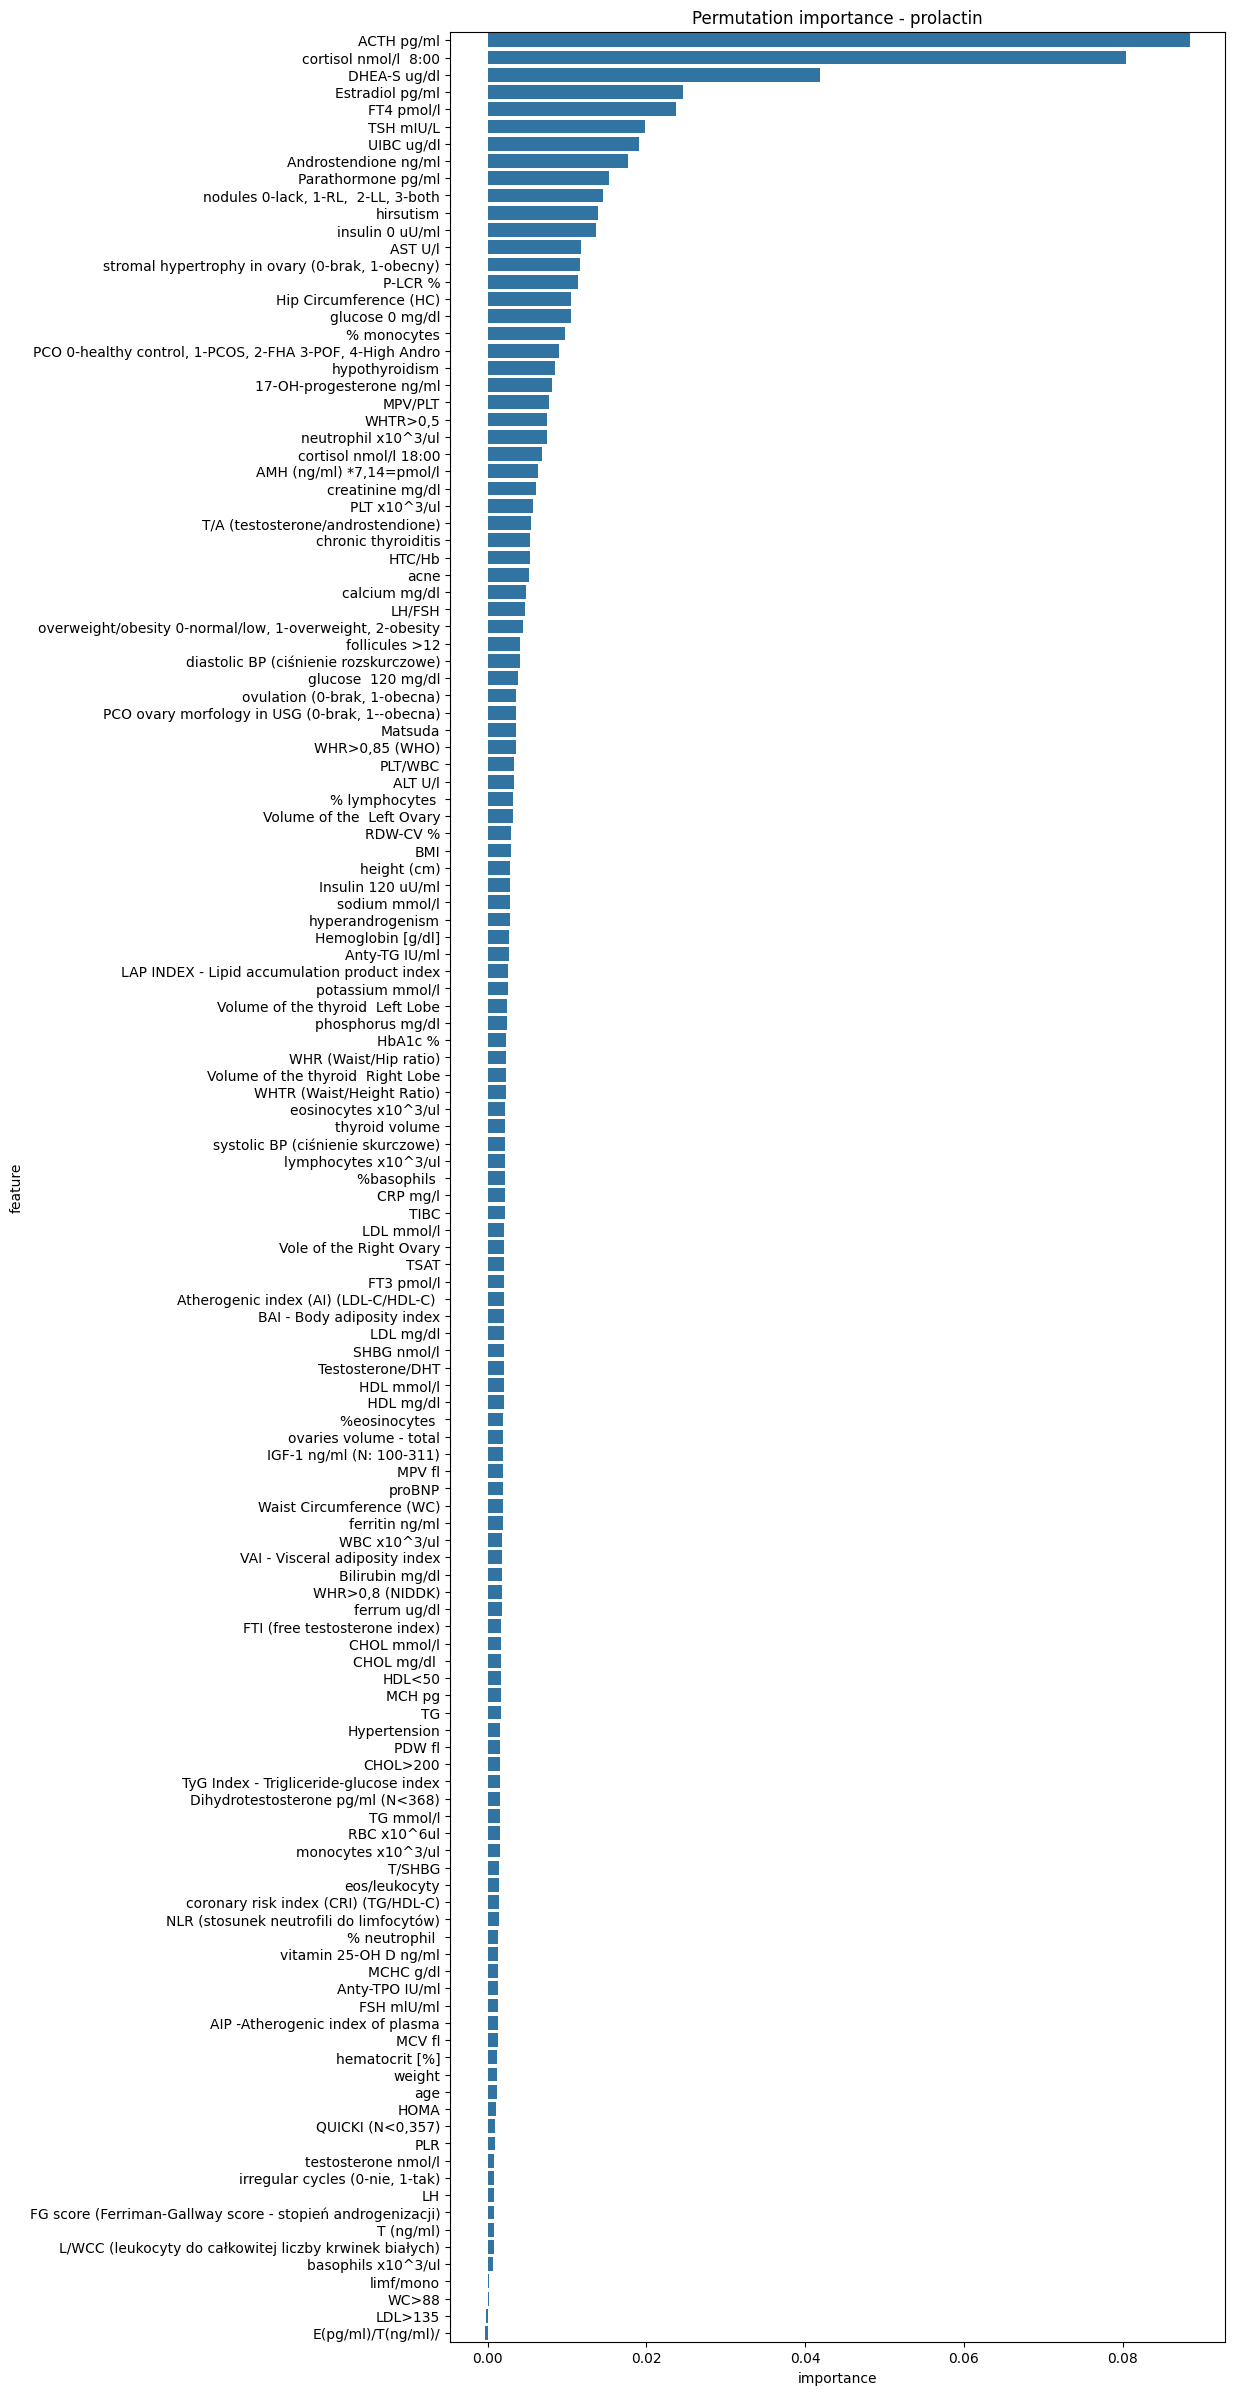

Actually selected 132 features


In [10]:
lasso_model = Lasso(alpha=2)

selected_features_permutation_importance = get_permutation_importance(X_train_prolactin, y_train_prolactin, lasso_model, continuous_preprocessor, categorical_preprocessor, PROLACTIN)
selected_features_permutation_importance = selected_features_permutation_importance[selected_features_permutation_importance['importance'] > 0]
selected_features_map['permutation_importance'] = list(selected_features_permutation_importance['feature'].values)
print(f'Actually selected {len(selected_features_map['permutation_importance'])} features')
# selected_features_permutation_importance

In [11]:
#  only mutual info & permutation importance
intersection_all_sets = set(selected_features_map[next(iter(selected_features_map))])

for key, items in selected_features_map.items():
    intersection_all_sets.intersection_update(items)


intersection_all_sets = list(intersection_all_sets)
print(len(intersection_all_sets))
print(intersection_all_sets)

pd.DataFrame(intersection_all_sets)

91
['AMH (ng/ml) *7,14=pmol/l', 'T (ng/ml)', 'FG score (Ferriman-Gallway score - stopień androgenizacji)', 'ACTH pg/ml', 'Matsuda', 'insulin 0 uU/ml', 'neutrophil x10^3/ul', 'CRP mg/l', 'diastolic BP (ciśnienie rozskurczowe)', 'ALT U/l', 'QUICKI (N<0,357)', 'HDL mmol/l', 'monocytes x10^3/ul', 'MPV fl', 'basophils x10^3/ul', 'TG mmol/l', 'irregular cycles (0-nie, 1-tak)', 'RBC x10^6ul', 'SHBG nmol/l', 'WHTR (Waist/Height Ratio)', 'phosphorus mg/dl', 'CHOL mg/dl ', 'CHOL mmol/l', 'BAI - Body adiposity index', 'LH', 'cortisol nmol/l  8:00', 'LAP INDEX - Lipid accumulation product index', 'CHOL>200', 'AST U/l', 'age', 'HOMA', 'Anty-TPO IU/ml', 'HbA1c %', 'TyG Index - Trigliceride-glucose index', 'BMI', '17-OH-progesterone ng/ml', 'hematocrit [%]', 'PLT x10^3/ul', 'T/SHBG', 'MCV fl', 'hyperandrogenism', 'PCO ovary morfology in USG (0-brak, 1--obecna)', 'RDW-CV %', ' HDL mg/dl', 'ovaries volume - total', 'P-LCR %', 'Insulin 120 uU/ml', 'LH/FSH', 'acne', 'overweight/obesity 0-normal/low, 1-ov

0
0                                     AMH (ng/ml) *7,14=pmol/l
1                                                    T (ng/ml)
2   FG score (Ferriman-Gallway score - stopień androgenizacji)
3                                                   ACTH pg/ml
4                                                      Matsuda
5                                              insulin 0 uU/ml
6                                          neutrophil x10^3/ul
7                                                     CRP mg/l
8                        diastolic BP (ciśnienie rozskurczowe)
9                                                      ALT U/l
10                                            QUICKI (N<0,357)
11                                                  HDL mmol/l
12                                          monocytes x10^3/ul
13                                                      MPV fl
14                                          basophils x10^3/ul
15                                                   TG mmol/l
16                             irregular cycles (0-nie, 1-tak)
17                                                 RBC x10^6ul
18                                                 SHBG nmol/l
19                                   WHTR (Waist/Height Ratio)
20                                            phosphorus mg/dl
21                                                 CHOL mg/dl 
22                                                 CHOL mmol/l
23                                  BAI - Body adiposity index
24                                                          LH
25                                       cortisol nmol/l  8:00
26                LAP INDEX - Lipid accumulation product index
27                                                    CHOL>200
28                                                     AST U/l
29                                                         age
30                                                        HOMA
31                                              Anty-TPO IU/ml
32                                                     HbA1c %
33                      TyG Index - Trigliceride-glucose index
34                                                         BMI
35                                    17-OH-progesterone ng/ml
36                                              hematocrit [%]
37                                                PLT x10^3/ul
38                                                      T/SHBG
39                                                      MCV fl
40                                            hyperandrogenism
41              PCO ovary morfology in USG (0-brak, 1--obecna)
42                                                    RDW-CV %
43                                                   HDL mg/dl
44                                      ovaries volume - total
45                                                     P-LCR %
46                                           Insulin 120 uU/ml
47                                                      LH/FSH
48                                                        acne
49    overweight/obesity 0-normal/low, 1-overweight, 2-obesity
50                                               sodium mmol/l
51                                                   hirsutism
52                                            Testosterone/DHT
53                                              follicules >12
54                                                Hypertension
55                           systolic BP (ciśnienie skurczowe)
56                                            potassium mmol/l
57                            AIP -Atherogenic index of plasma
58                                   Volume of the  Left Ovary
59                                                 %basophils 
60                                                  LDL mmol/l
61                                                    WHTR>0,5
62                                    Waist Circumference (WC)
63                           

In [26]:
intersection_all_sets = set(selected_features_map[next(iter(selected_features_map))])

for key, items in selected_features_map.items():
    intersection_all_sets.intersection_update(items)


intersection_all_sets = list(intersection_all_sets)
print(len(intersection_all_sets))
print(intersection_all_sets)

pd.DataFrame(intersection_all_sets)

15
['FT4 pmol/l', 'PLT x10^3/ul', 'hirsutism', '17-OH-progesterone ng/ml', 'P-LCR %', 'AST U/l', 'glucose 0 mg/dl', 'AMH (ng/ml) *7,14=pmol/l', 'DHEA-S ug/dl', 'ACTH pg/ml', 'Androstendione ng/ml', 'WHTR>0,5', 'Parathormone pg/ml', 'insulin 0 uU/ml', 'cortisol nmol/l  8:00']


0
0                 FT4 pmol/l
1               PLT x10^3/ul
2                  hirsutism
3   17-OH-progesterone ng/ml
4                    P-LCR %
5                    AST U/l
6            glucose 0 mg/dl
7   AMH (ng/ml) *7,14=pmol/l
8               DHEA-S ug/dl
9                 ACTH pg/ml
10      Androstendione ng/ml
11                  WHTR>0,5
12        Parathormone pg/ml
13           insulin 0 uU/ml
14     cortisol nmol/l  8:00

In [27]:
union_all_sets = set(selected_features_map[next(iter(selected_features_map))]) 

for key, items in selected_features_map.items():
    union_all_sets.update(items)
    

union_all_sets = list(union_all_sets)
print(len(union_all_sets))
print(union_all_sets)

107
['glucose  120 mg/dl', 'E(pg/ml)/T(ng/ml)/', ' HDL mg/dl', 'UIBC ug/dl', 'Volume of the  Left Ovary', 'hypothyroidism', 'LH', '17-OH-progesterone ng/ml', 'ferritin ng/ml', 'TSH mIU/L', 'T (ng/ml)', 'weight', 'MPV fl', 'testosterone nmol/l', 'LH/FSH', 'hirsutism', 'LDL mmol/l', 'neutrophil x10^3/ul', 'FT3 pmol/l', 'IGF-1 ng/ml (N: 100-311)', 'systolic BP (ciśnienie skurczowe)', 'WC>88', 'LAP INDEX - Lipid accumulation product index', 'BMI', 'monocytes x10^3/ul', 'eosinocytes x10^3/ul', 'WHR>0,8 (NIDDK)', 'age', 'Anty-TPO IU/ml', 'MPV/PLT', 'Hemoglobin [g/dl]', '%basophils ', '% lymphocytes ', '%eosinocytes ', 'height (cm)', 'BAI - Body adiposity index', 'ALT U/l', 'WHR (Waist/Hip ratio)', 'stromal hypertrophy in ovary (0-brak, 1-obecny)', 'diastolic BP (ciśnienie rozskurczowe)', 'RDW-CV %', 'LDL mg/dl', 'MCV fl', 'CHOL mg/dl ', 'Insulin 120 uU/ml', 'WHTR>0,5', 'Hypertension', 'nodules 0-lack, 1-RL,  2-LL, 3-both', 'HOMA', 'CHOL mmol/l', 'PLT x10^3/ul', 'T/SHBG', 'overweight/obesity 

## Test the narrowed down feature space

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


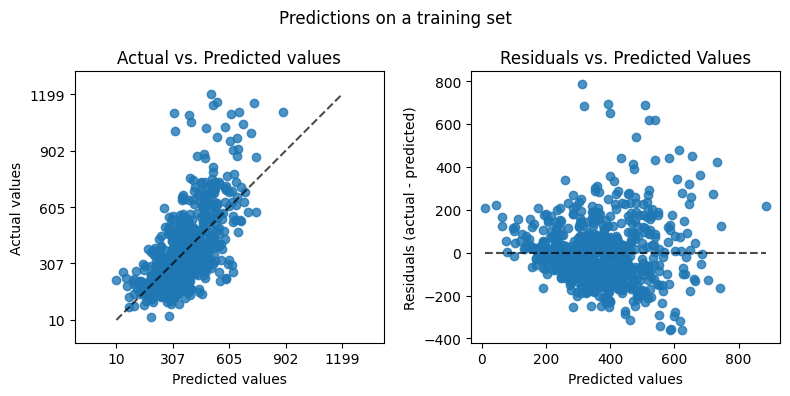

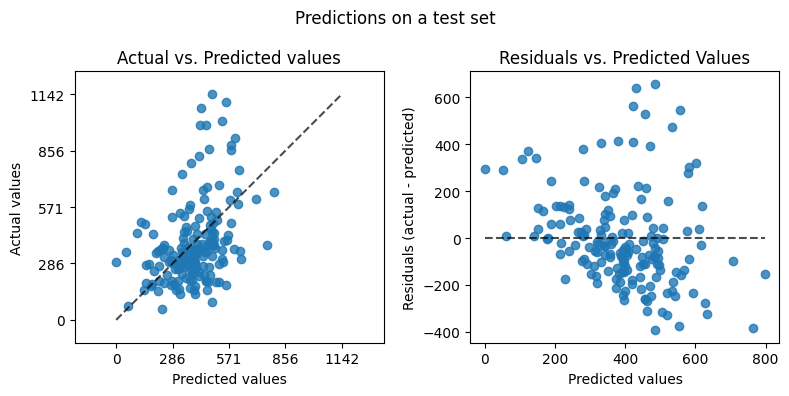

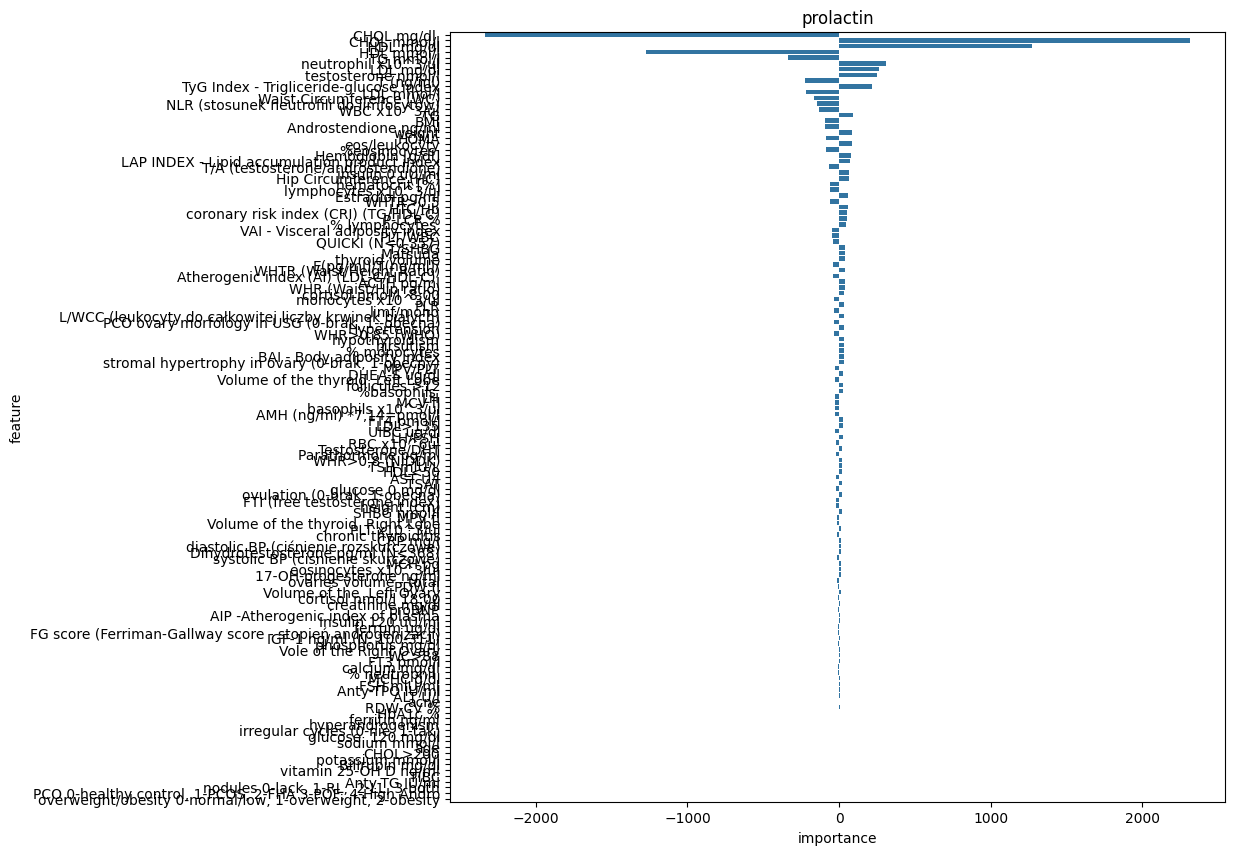

model  data_set        mse      mae     rmse     r2
0  LinearRegression()  training  23665.592  113.443  153.836  0.398
1  LinearRegression()      test  40370.943  151.326  200.925  0.076

In [28]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

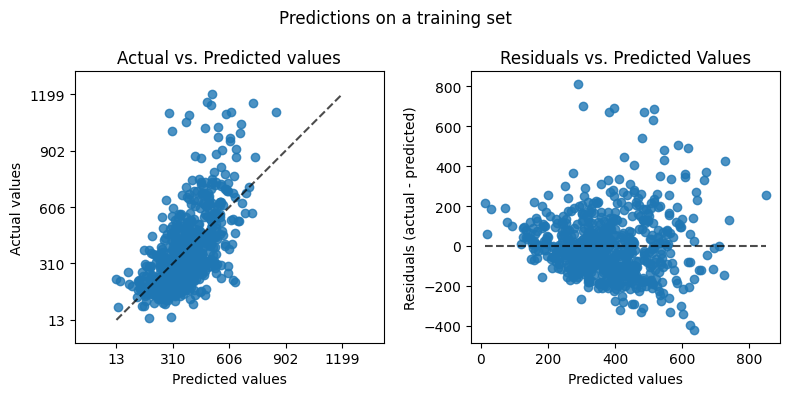

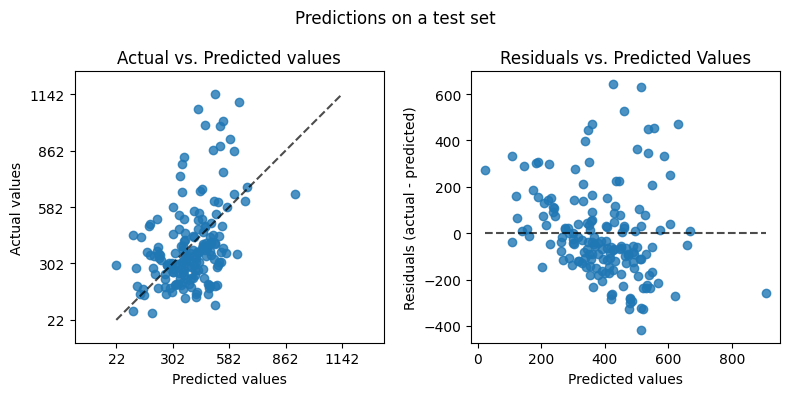

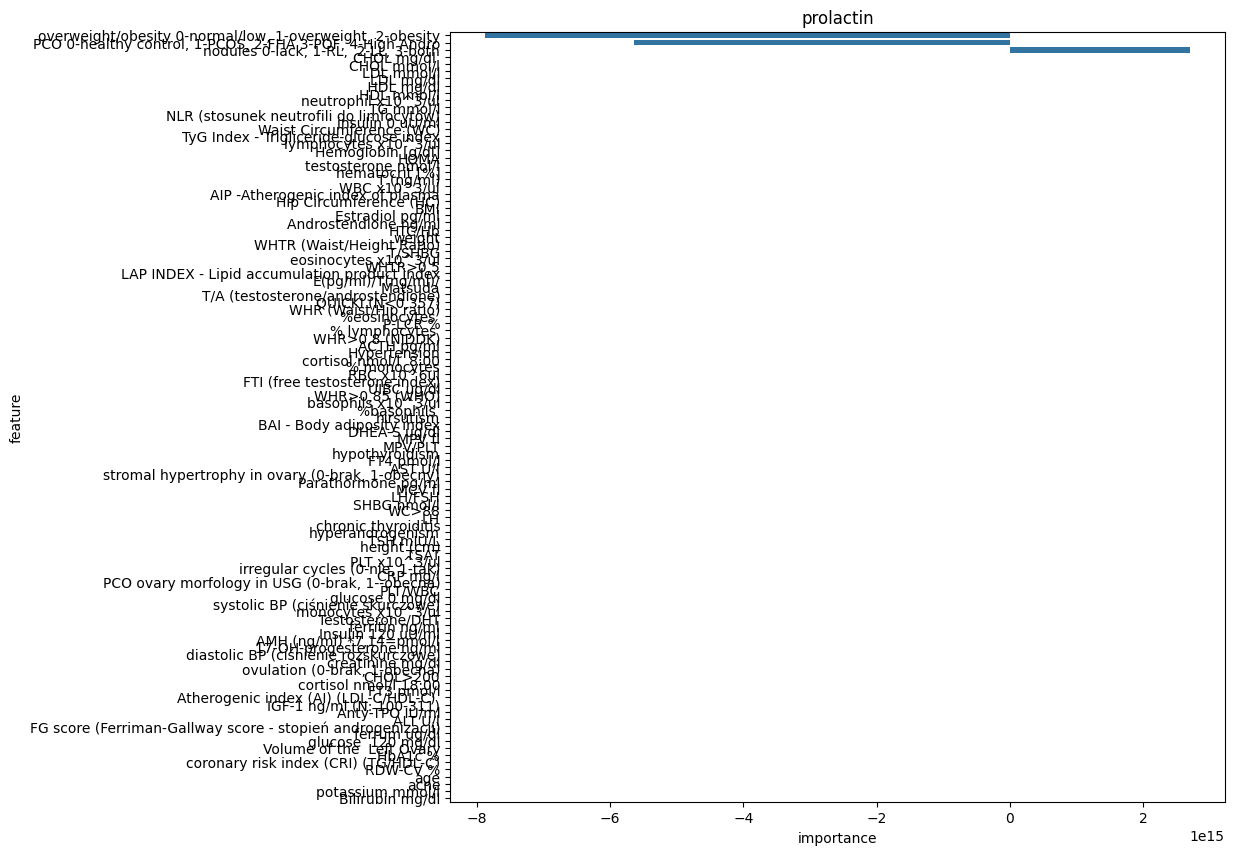

model  data_set        mse      mae     rmse     r2
0  LinearRegression()  training  24805.681  115.875  157.498  0.368
1  LinearRegression()      test  37999.442  148.186  194.934  0.130

In [29]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, PROLACTIN, X_train_prolactin[union_all_sets], y_train_prolactin, X_test_prolactin[union_all_sets], y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

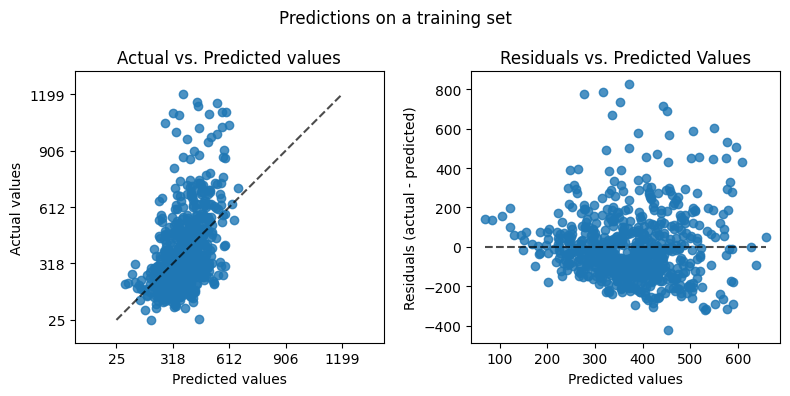

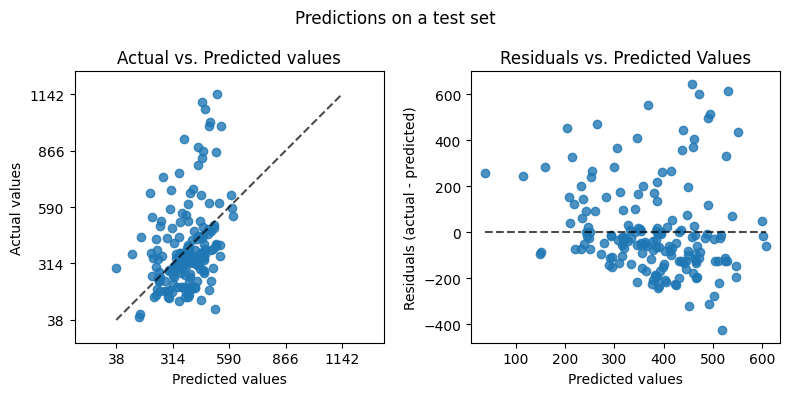

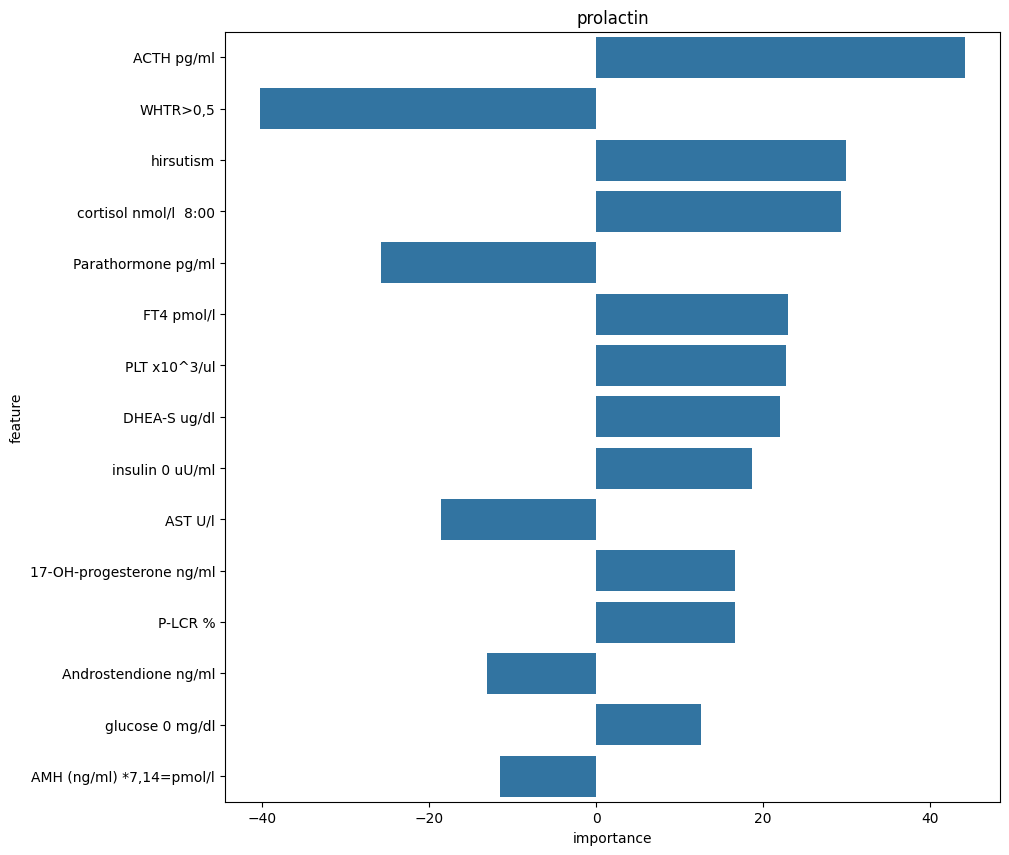

model  data_set        mse      mae     rmse     r2
0  LinearRegression()  training  30480.464  127.723  174.587  0.224
1  LinearRegression()      test  39220.278  144.921  198.041  0.102

In [30]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, PROLACTIN, X_train_prolactin[intersection_all_sets], y_train_prolactin, X_test_prolactin[intersection_all_sets], y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

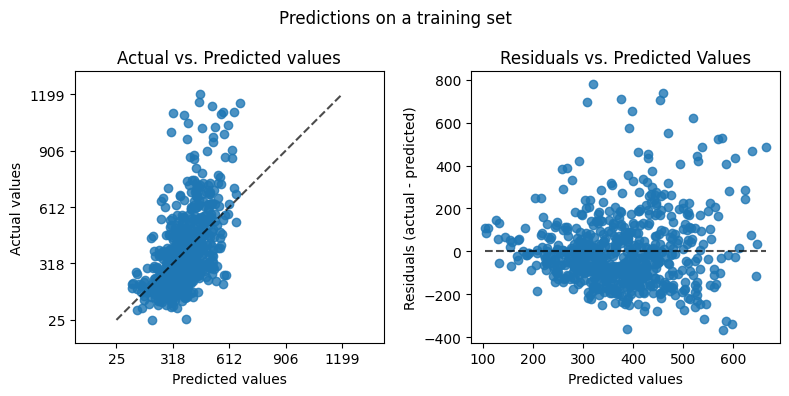

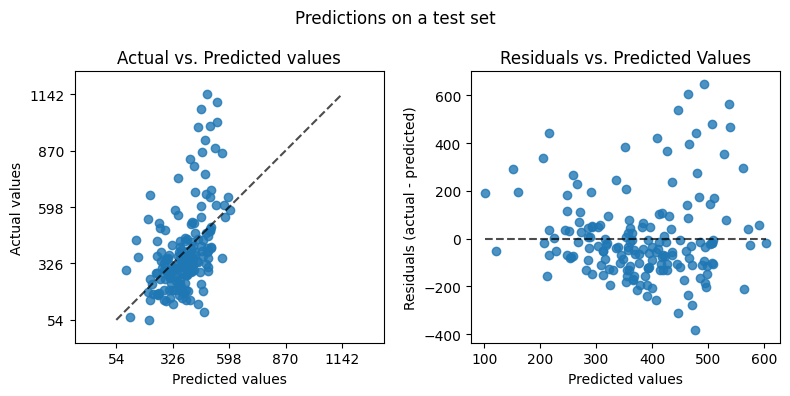

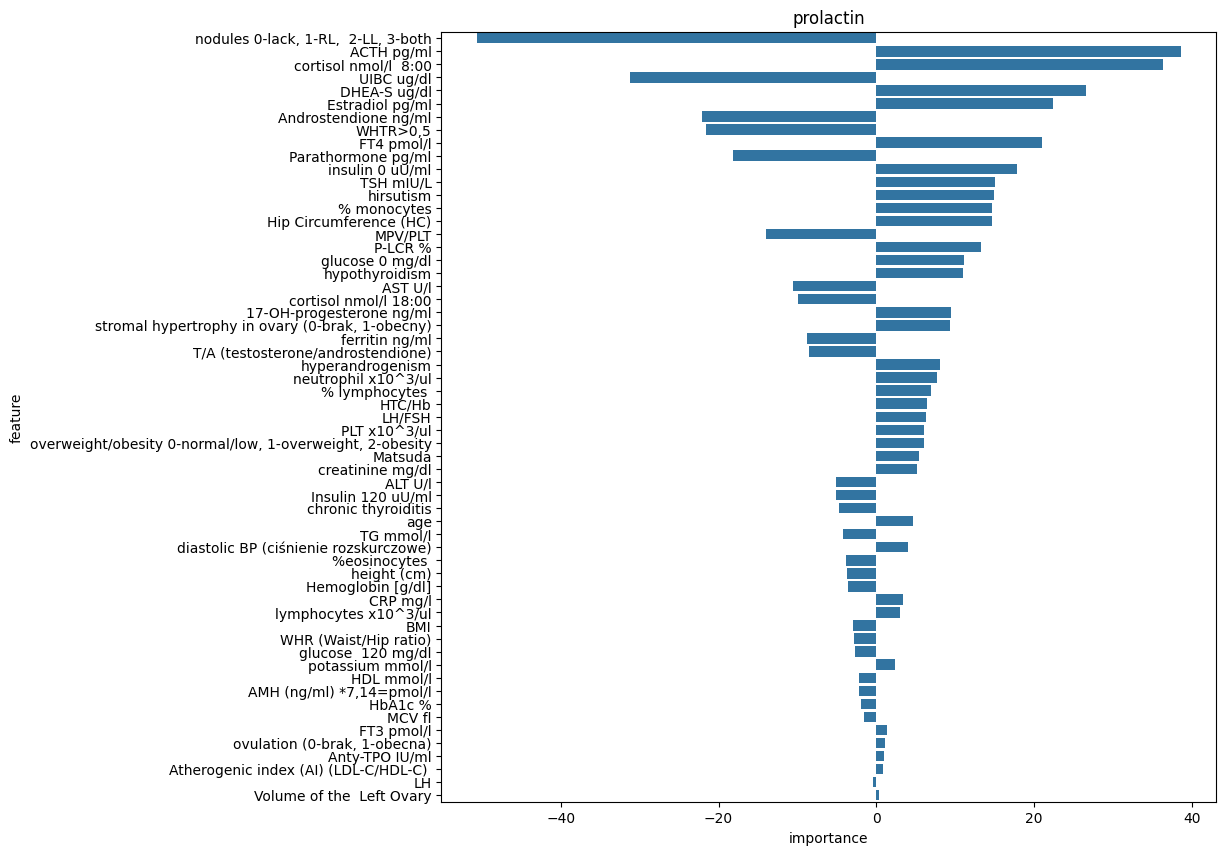

model  data_set        mse      mae     rmse     r2
0  Lasso(alpha=2)  training  27253.189  120.765  165.085  0.306
1  Lasso(alpha=2)      test  33309.190  131.649  182.508  0.238

In [31]:
lasso_model = Lasso(alpha=2)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, PROLACTIN, X_train_prolactin[union_all_sets], y_train_prolactin, X_test_prolactin[union_all_sets], y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

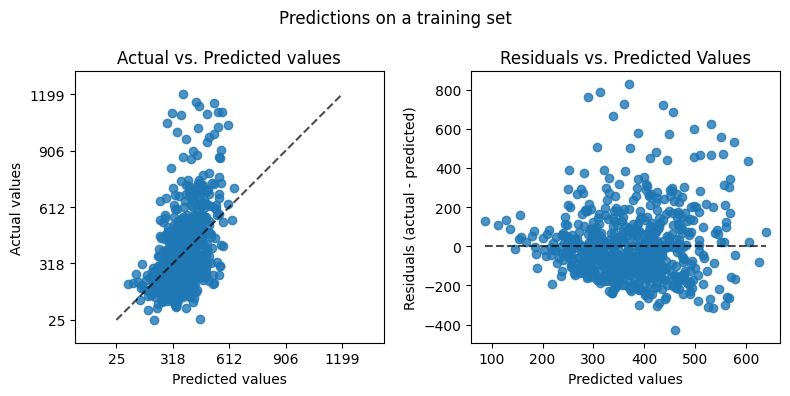

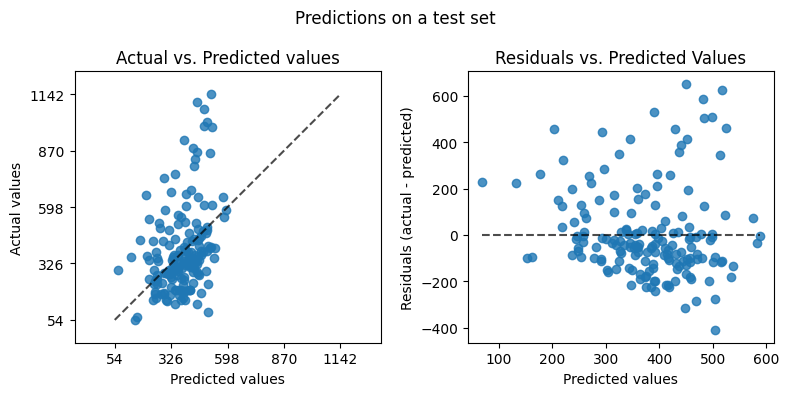

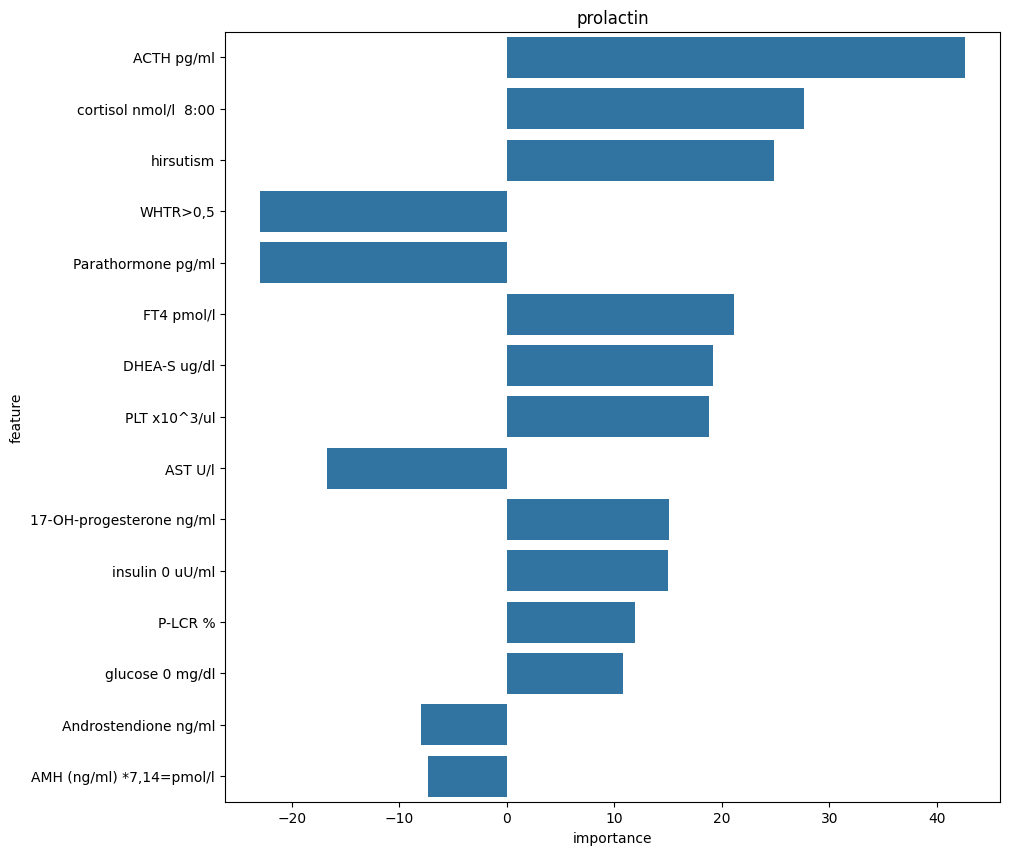

model  data_set        mse      mae     rmse     r2
0  Lasso(alpha=2)  training  30600.363  127.744  174.930  0.221
1  Lasso(alpha=2)      test  38351.867  143.008  195.836  0.122

In [32]:
lasso_model = Lasso(alpha=2)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, PROLACTIN, X_train_prolactin[intersection_all_sets], y_train_prolactin, X_test_prolactin[intersection_all_sets], y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

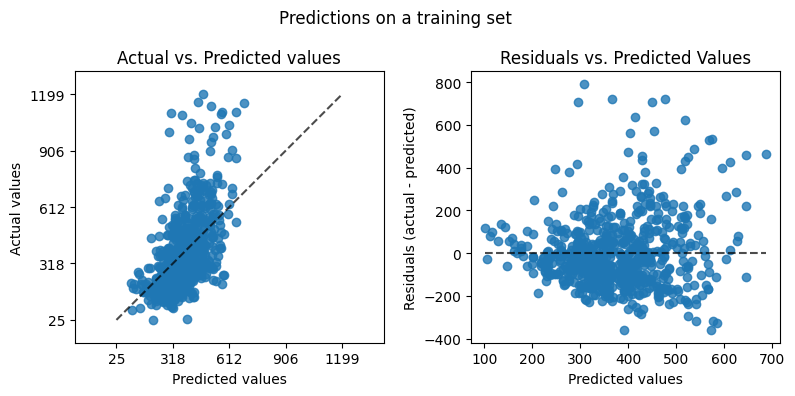

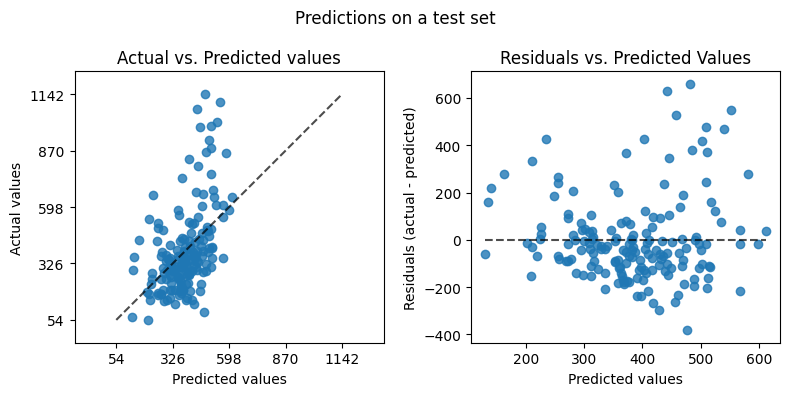

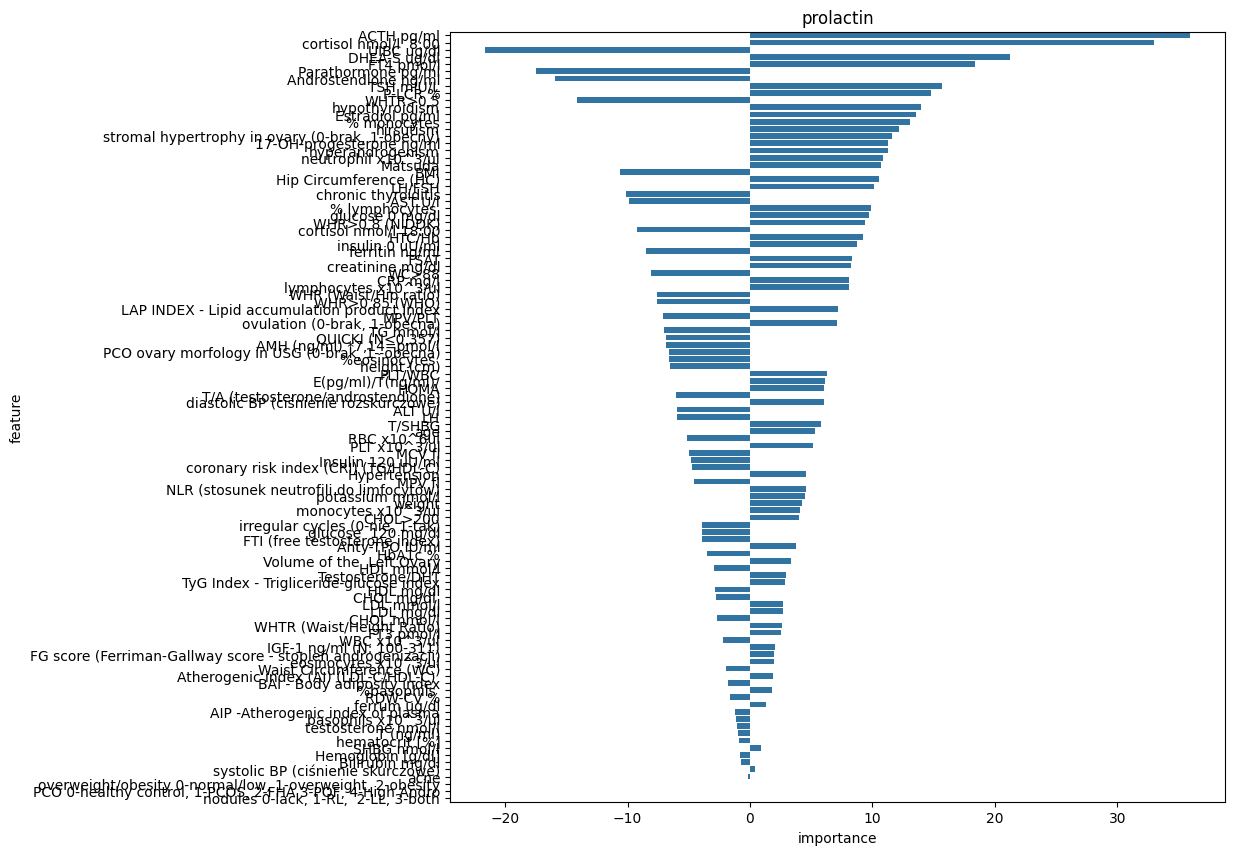

model  data_set        mse      mae     rmse     r2
0  Ridge(alpha=100)  training  26960.872  120.108  164.198  0.314
1  Ridge(alpha=100)      test  33119.900  131.220  181.989  0.242

In [33]:
ridge_model = Ridge(alpha=100)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, PROLACTIN, X_train_prolactin[union_all_sets], y_train_prolactin, X_test_prolactin[union_all_sets], y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

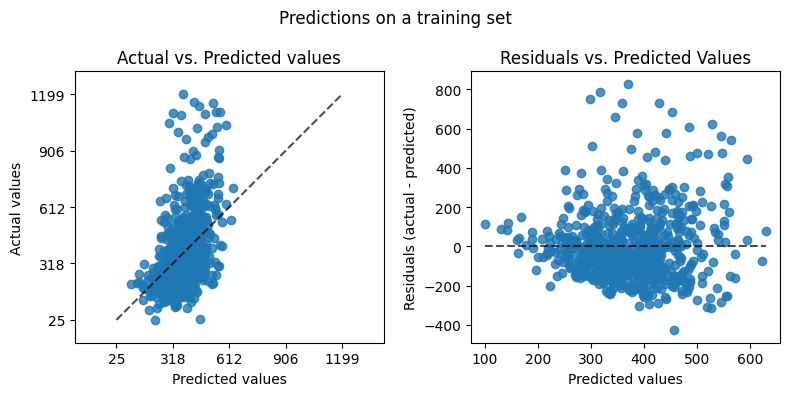

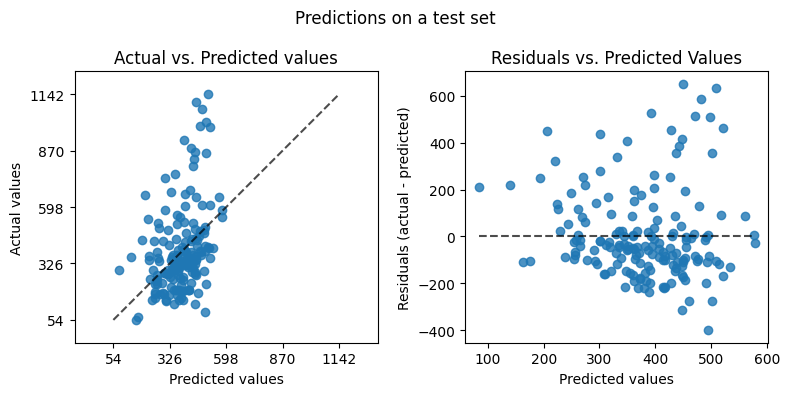

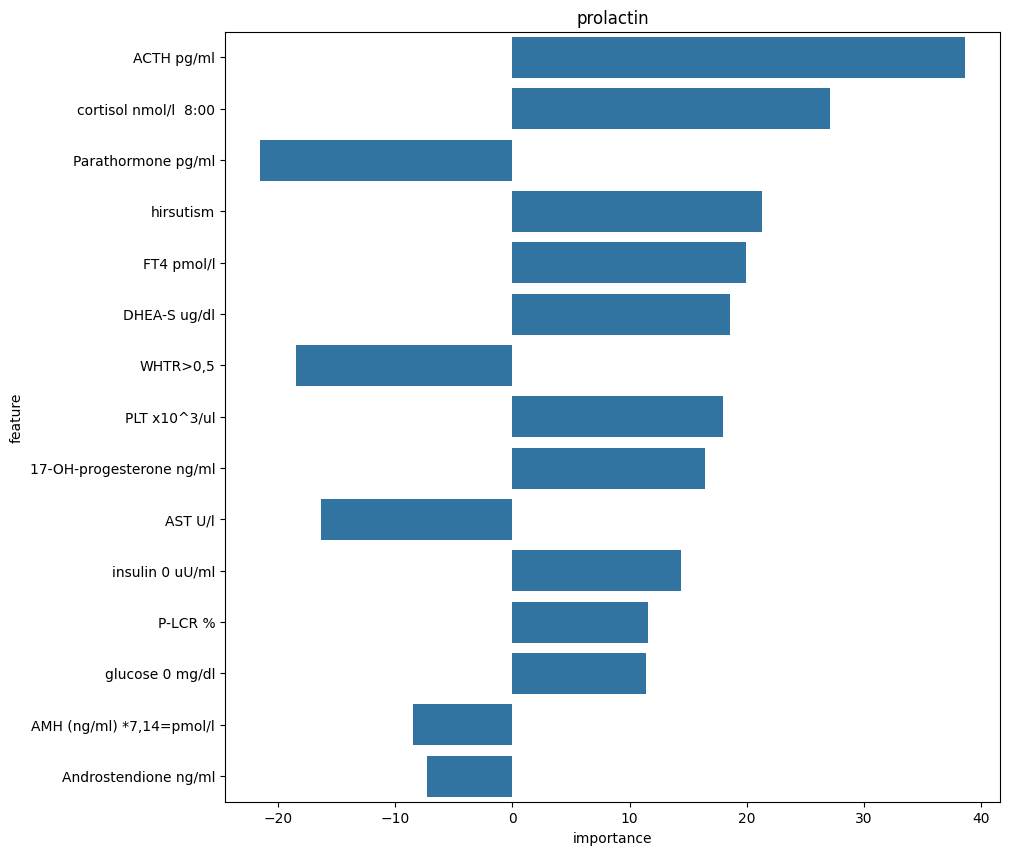

model  data_set        mse      mae     rmse     r2
0  Ridge(alpha=100)  training  30687.170  127.859  175.178  0.219
1  Ridge(alpha=100)      test  38015.888  142.488  194.977  0.130

In [34]:
ridge_model = Ridge(alpha=100)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, PROLACTIN, X_train_prolactin[intersection_all_sets], y_train_prolactin, X_test_prolactin[intersection_all_sets], y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

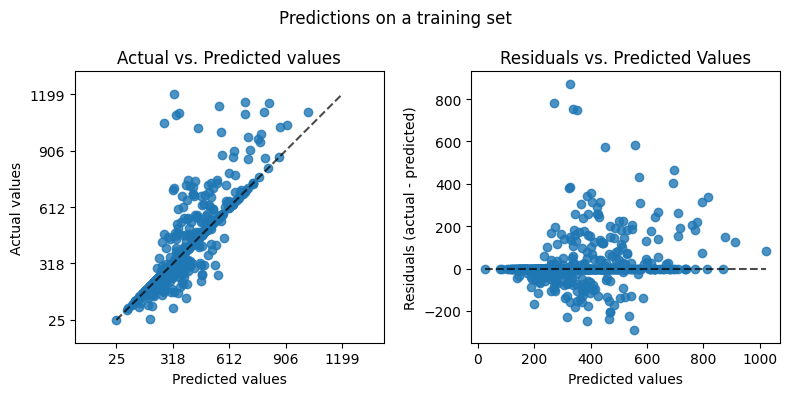

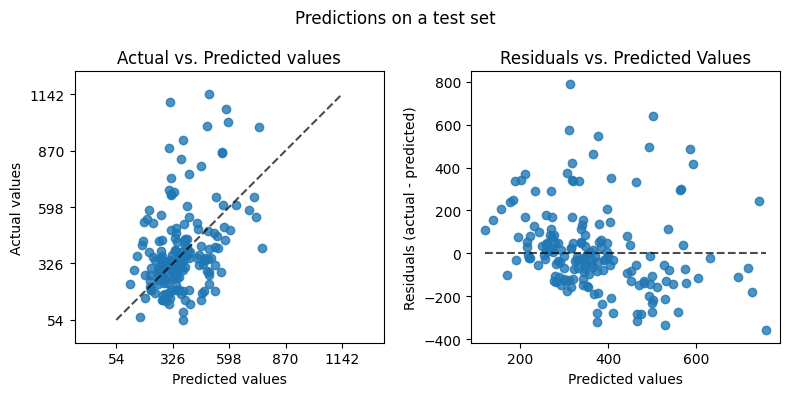

AttributeError: coef_ is only available when using a linear kernel

In [58]:
from sklearn.svm import SVR

knn_model = SVR(kernel='rbf', C=1000, epsilon=0.2)

vit_d_model_scores_df, feature_importnces_knn = train_model(knn_model, PROLACTIN, X_train_prolactin[intersection_all_sets], y_train_prolactin, X_test_prolactin[intersection_all_sets], y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

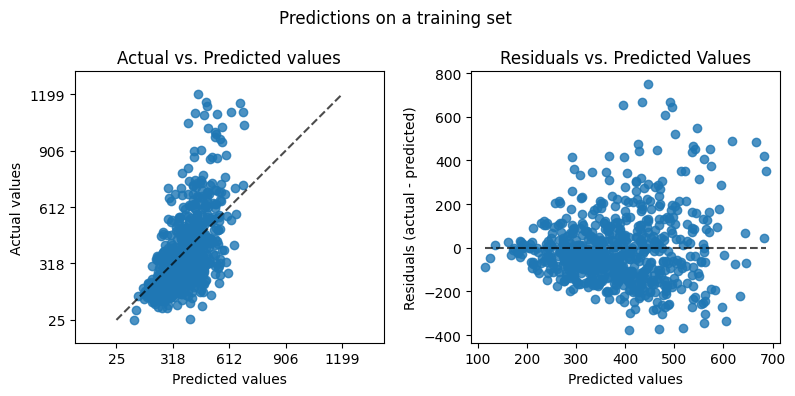

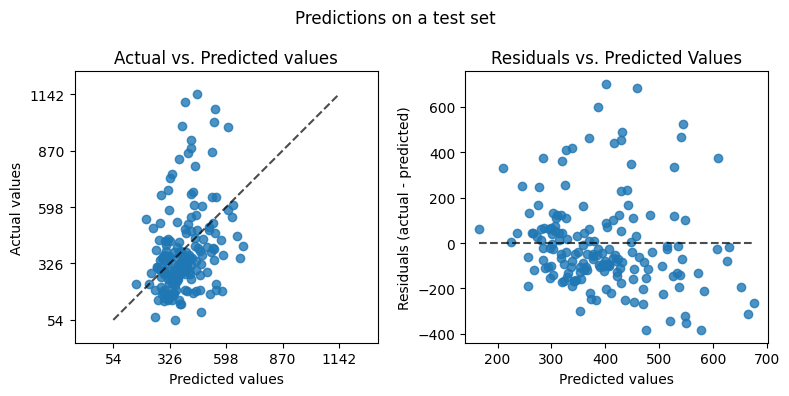

AttributeError: 'KNeighborsRegressor' object has no attribute 'coef_'

In [47]:
from sklearn.neighbors import KNeighborsRegressor


knn_model = KNeighborsRegressor(n_neighbors=6)

vit_d_model_scores_df, feature_importnces_knn = train_model(knn_model, PROLACTIN, X_train_prolactin[intersection_all_sets], y_train_prolactin, X_test_prolactin[intersection_all_sets], y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df